# Audio Calculator

In [10]:
#documentation: https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html
from sklearn.ensemble import RandomForestClassifier
from python_speech_features import mfcc
from python_speech_features import logfbank
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import scipy.io.wavfile as wav
import glob
import sys
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import seaborn as sn

## Find relative path

In [11]:
import os

if os.getcwd().endswith("Calculator") == True or \
   os.getcwd().endswith("Calculator\\") == True or \
   os.getcwd().endswith("Calculator/") == True :
    cwd = os.getcwd()

print(cwd)

C:\Users\qan96\Documents\GitHub\Audio-Calculator


## Auxilary functions

In [12]:
def join_features(mfcc, fbank):
    features = np.concatenate((mfcc, fbank), axis=1)
    return features

truncate_threshold = 0.1
truncate_size = 10000.0
pre_emphasis = 0.97

def normalize(signal):
    result = abs(signal).copy().astype('float64')
    xmin = np.min(result)
    xmax = np.max(result)
    for i in range(0, signal.size):
        result[i] = (result[i] - xmin) / (xmax - xmin)
        result[i] = "%.2f" % result[i]
    
    return result

def calculate_normalized_entropy(signal):
    #normalize
    signal = normalize(signal)
    
    p = np.zeros(101)
    for i in range(0, signal.size):
        p[(signal[i] / 0.01).astype('int64')] += 1
    
    p = p / signal.size
    max_entro = 0.0
    min_entro = 1.0
    entropy = np.zeros(signal.size)
    
    for i in range(0, signal.size):
        index = (signal[i] / 0.01).astype('int64')
        entropy[i] = -p[index]*math.log2(p[index])
        max_entro = max(max_entro, entropy[i])
        min_entro = min(min_entro, entropy[i])
        
    for i in range(0,100):
        if p[i] == 0:
            continue
        #print(-p[i]*math.log2(p[i]))
        
    lamb = (max_entro - min_entro) / 2.0
    return entropy, lamb
    
def plot_sig(sig, ylabel):
    plt.figure()
    plt.plot(sig)
    plt.xlabel("time [s]")
    plt.ylabel(ylabel)
    plt.show()

def preprocess(sig, enable_plot = False, pre_emphasis = False):
    if enable_plot == True:
        plot_sig(sig, "before preprocess")
        
    if pre_emphasis == True:
        sig = np.append(sig[0], sig[1:] - pre_emphasis * sig[:-1])
        
    start_point = 0
    threshold = 0.1
    norm_sig = normalize(sig)
    if enable_plot == True:
        plot_sig(norm_sig, "after normalization")
    
    for i in range(0, sig.size):
        if norm_sig[i] >= truncate_threshold:
            start_point = i
            break
    
    stop_point = sig.size
    for i in reversed(range(0, sig.size)):
        if norm_sig[i] >= (truncate_threshold):
            stop_point = i
            break
    
    #print("start point", start_point)
    #print("stop point", stop_point)
    sig = sig[start_point:stop_point]
    #print(sig.size)
    if enable_plot == True:
        plot_sig(sig, "after truncation")
        
    #strech sig to 6000
    sig = librosa.core.resample(sig, sig.size, truncate_size)
    
    if enable_plot == True:
        plot_sig(sig, "after resampling")
    #sig = truncate_sig(sig)
    
    return sig
    
def read_file(files, label, enable_plot=False):
    features = []
    labels = []
    for file in files:
        (rate,sig) = wav.read(file)
        
        sig, sample_rate = librosa.core.load(file)
        #entropy, lamb = calculate_normalized_entropy(sig)
        
        sig = preprocess(sig, enable_plot)
        
        mfcc_feat = mfcc(sig, rate, nfft=1536)
        fbank_feat = logfbank(sig, rate, nfft=1536)    
        acoustic_features = join_features(mfcc_feat, fbank_feat)
        acoustic_features = acoustic_features.flatten()
        features.append(acoustic_features)
        labels.append(label)
        
    return features, labels
        
digit_feature_types = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight",\
                 "nine"]

feature_types = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight",\
                 "nine", "plus", "minus", "times", "over"]

op_feature_types = ["plus", "minus", "times", "over"]

## Load sample data

In [13]:
digit_features = []
digit_labels = []
op_features = []
op_labels = []
for i in digit_feature_types:
    if sys.platform.startswith('win32'):
         os.chdir(cwd+"\\recording data\\" + i + "\\")
    elif sys.platform.startswith('darwin'):
         os.chdir(cwd+"/recording data/" + i + "/")
    
    files = glob.glob(os.path.join(os.getcwd(), '*.wav') )
    features, labels = read_file(files, i, False)
    digit_features.extend(features)
    digit_labels.extend(labels)
    print(i, "finished")

for i in op_feature_types:
    if sys.platform.startswith('win32'):
         os.chdir(cwd+"\\recording data\\" + i + "\\")
    elif sys.platform.startswith('darwin'):
         os.chdir(cwd+"/recording data/" + i + "/")
    
    files = glob.glob(os.path.join(os.getcwd(), '*.wav') )
    features, labels = read_file(files, i, False)
    op_features.extend(features)
    op_labels.extend(labels)
    
    print(i, "finished")
    
print("Input and preprocessing finished")

zero finished
one finished
two finished
three finished
four finished
five finished
six finished
seven finished
eight finished
nine finished


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


plus finished
minus finished
times finished
over finished
Input and preprocessing finished


## Backup raw design matrices

In [14]:
digit_features = np.asarray(digit_features)
digit_labels = np. asarray(digit_labels)
op_features = np.asarray(op_features)
op_labels = np. asarray(op_labels)

digit_features_backup = digit_features.copy()
digit_labels_backup = digit_labels.copy()
op_features_backup = op_features.copy()
op_labels_backup = op_labels.copy()


## Retrieve features from backup

In [15]:
digit_features = digit_features_backup.copy()
digit_labels = digit_labels_backup.copy()


print(pd.DataFrame(digit_features))

print(digit_features.shape)
print(digit_labels.shape)
print(op_features.shape)
print(op_labels.shape)

           0          1          2          3          4          5     \
0     -4.898897   5.244830   9.305145   8.679893   6.108264   1.208800   
1     -5.689415   2.605010   6.298211   7.067905  15.659499  12.817506   
2     -6.317494   3.443348   6.517565   9.527452   2.759677  -2.336275   
3     -5.998414   3.532424   1.527295  10.781296  17.273593   1.269391   
4     -5.475949   4.702537  -5.969042  -2.817859  19.371516  24.957718   
5     -6.440540   2.483213   8.811690   7.401686   6.817587   4.463255   
6     -6.419075   2.586243   7.658047  10.631767   4.070762  -3.032648   
7     -7.082432   1.079952   6.031781   6.193761   2.863267   1.061565   
8     -6.030508   1.934775   2.995217   4.024479  14.021593   8.872403   
9     -5.874285   2.441809   3.532756   4.240077  13.266041   7.567142   
10    -6.090820   3.532250   7.720346   9.061982   5.279696  -1.222235   
11    -6.053360   1.481751   4.727420   8.482877   5.226138  -3.103506   
12    -5.736554   4.378426   6.981616 

## Feature validation

In [16]:
#validate features and labels
for i in range(1, digit_features.shape[0]):
    if digit_features[i].size != digit_features[0].size:
        print("digit features", i)
        print(digit_features[i].size)
    if digit_labels[i].size != 1:
        print("digit labels", i)
        print(digit_labels[i].size)

## Normalization and PCA feature selection

In [17]:
# digit_scaler = StandardScaler()
# # Fit on training set only.
# digit_scaler.fit(digit_features)

# digit_train_set = digit_scaler.transform(digit_train_set)
# digit_test_set = digit_scaler.transform(digit_test_set)

# digit_pca = PCA(.95)
# digit_pca.fit(digit_features)
# digit_train_set = digit_pca.transform(digit_train_set)
# digit_test_set = digit_pca.transform(digit_test_set)

## Logistic regression

In [18]:
digit_train_set, digit_test_set, digit_train_label, digit_test_label = train_test_split(digit_features, digit_labels, test_size=0.2, random_state=0, stratify=digit_labels)
op_train_set, op_test_set, op_train_label, op_test_label = train_test_split(op_features, op_labels, test_size=0.2, random_state=0, stratify=op_labels)
print(digit_features.shape[0])

2000


In [19]:
digit_logisticRegr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', penalty = 'l2', max_iter = 10000)

digit_logisticRegr.fit(digit_train_set, digit_train_label)

print("test set accuracy: ", digit_logisticRegr.score(digit_test_set, digit_test_label) * 100, "%")
print("train set accuracy: ", digit_logisticRegr.score(digit_train_set, digit_train_label) * 100, "%")

test set accuracy:  80.5 %
train set accuracy:  100.0 %


[[32  0  2  0  0  1  2  1  1  1]
 [ 0 29  1  3  1  5  0  1  0  0]
 [ 0  0 37  0  0  0  0  1  2  0]
 [ 0  2  0 32  5  1  0  0  0  0]
 [ 1  1  0  1 36  0  0  0  0  1]
 [ 2  1  0  0  0 32  1  1  2  1]
 [ 9  0  5  0  0  0 24  1  1  0]
 [ 0  0  0  0  1  0  3 29  7  0]
 [ 1  0  0  0  0  0  1  6 32  0]
 [ 0  0  0  0  0  0  1  0  0 39]]


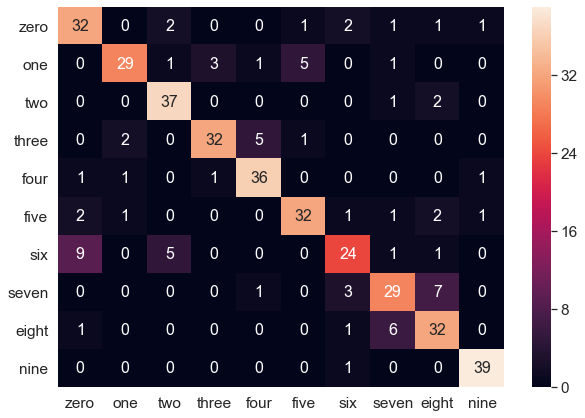

In [20]:
pred = digit_logisticRegr.predict(digit_test_set)
cm = confusion_matrix(digit_test_label, pred)
print(cm)
df_cm = pd.DataFrame(cm, index = [i for i in digit_feature_types],
                  columns = [i for i in digit_feature_types])
plt.figure(figsize = (10,7))

sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
plt.show()

In [21]:
op_logisticRegr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', penalty = 'l2')

op_logisticRegr.fit(op_train_set, op_train_label)

print("test set accuracy: ", op_logisticRegr.score(op_test_set, op_test_label) * 100, "%")
print("train set accuracy: ", op_logisticRegr.score(op_train_set, op_train_label) * 100, "%")

test set accuracy:  95.40229885057471 %
train set accuracy:  100.0 %


C:\Users\qan96\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[[23  0  0  0]
 [ 0 20  0  2]
 [ 1  0 18  1]
 [ 0  0  0 22]]


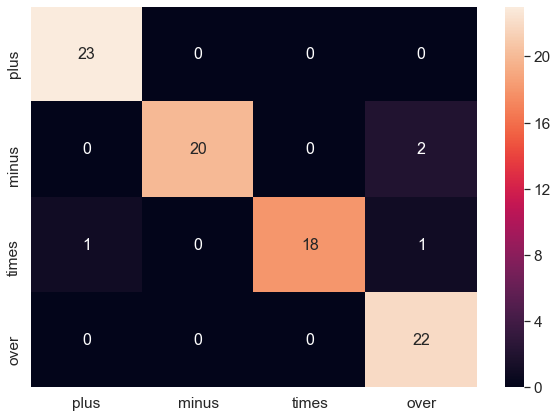

In [22]:
pred = op_logisticRegr.predict(op_test_set)
cm = confusion_matrix(op_test_label, pred)
print(cm)
df_cm = pd.DataFrame(cm, index = [i for i in op_feature_types],
                  columns = [i for i in op_feature_types])
plt.figure(figsize = (10,7))

sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
plt.show()

In [23]:
# for i in range(0, op_test_set.shape[0]):
#     if test_label[i] in op_feature_types:
#         result = op_logisticRegr.predict(op_test_set[i].reshape(1,-1))
#         if (result != op_test_label[i]):
#             print("Correct result:" + op_test_label[i])
#             print(result)

In [24]:
digit_rfc = RandomForestClassifier(n_estimators = 150)
digit_X_train, digit_X_val, digit_y_train, digit_y_val = train_test_split(digit_features, digit_labels, test_size=0.2, random_state=10, shuffle = True, stratify=digit_labels)

digit_rfc.fit(digit_X_train, digit_y_train)
#checking the accuracy of the model
print(digit_rfc.score(digit_X_val, digit_y_val))

0.9125


[[38  0  0  0  0  0  2  0  0  0]
 [ 0 33  3  1  2  0  0  0  0  1]
 [ 0  0 38  0  1  0  0  0  0  1]
 [ 0  1  0 38  0  1  0  0  0  0]
 [ 0  0  0  2 38  0  0  0  0  0]
 [ 0  1  0  1  0 37  0  0  1  0]
 [ 6  0  0  0  0  0 33  1  0  0]
 [ 0  0  0  0  0  0  1 35  4  0]
 [ 0  0  0  0  0  0  0  2 38  0]
 [ 0  0  0  0  0  2  1  0  0 37]]


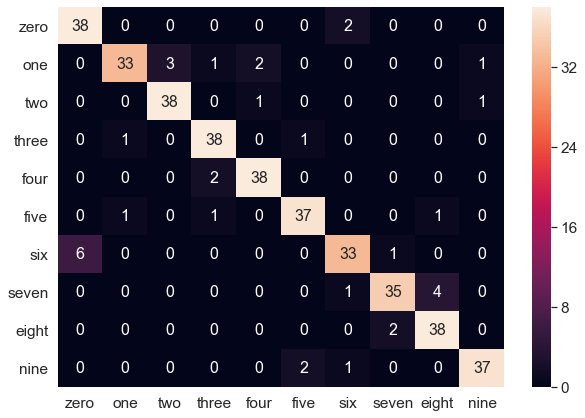

In [25]:
pred = digit_rfc.predict(digit_X_val)
cm = confusion_matrix(digit_y_val, pred)
print(cm)
df_cm = pd.DataFrame(cm, index = [i for i in digit_feature_types],
                  columns = [i for i in digit_feature_types])
plt.figure(figsize = (10,7))

sn.set(font_scale=1.4)#for label sizedata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAkkAAAGiCAYAAADz61LoAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjAsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+17YcXAAAgAElEQVR4nOzdeVxU1f/H8RcwICiioqjfFGRTTE2z3HKL3Lf0q1/LfUVNESz3Fcx9w/zivmRpuX1zw91ILRXNtbJcUjDM0sSVHWX9/cFPChkEmTtz5+Ln+XjM45FnZs68Pd3BD+eee65FRkZGBkIIIYQQIhtLtQMIIYQQQpgjKZKEEEIIIfSQIkkIIYQQQg8pkoQQQggh9JAiSQghhBBCDymShBBCCCH00KkdwFSe/HpU7QgvpFjNnmpHEOKlVMrOXu0ILywx5YnaEV7Yk9QUtSMUeqnJt0z6eSn3f1OsL+sy7or1ZQiZSRJCCCGE0OOlmUkSQgghhBGlp6mdQHFSJAkhhBDCcBnpaidQnJxuE0IIIYTQQ2aShBBCCGG49MI3kyRFkhBCCCEMliGn24QQQgghXg4ykySEEEIIw8npNiGEEEIIPeR0mxBCCCHEy0FmkoQQQghhuEK4maTMJOVDSkoqSzaE0HrQBOq974fPlIVcvv47ALsOn6RmpyG5PsyJz8CeXLkURlxMBGHHdtOg/ptqR8qT1jJrLS9IZmOztLRk6PD+nDiznxu3fyTs9D58BvdSO1a+tWvfgjtRF9WOkS9aOi5Ae3nzlJGu3MNMSJGUD/PXfsWmvUcY+J82/HfiMOyK2DBoykJu331Akzqv8eX8CdkeiycPx8ZaR5eWjdWOnqV3764sXzaXTZu38363IURHx7B/30ZcXZ3VjpYrrWXWWl6QzKYwepwvkwNHse2r3fTpMYxdOw8wc+4k/D4cpHa0PNWv/wZr1y7CwsJC7Sh50tpxobW8LyuLjIyMDLVDmMKTX48W6H1xCYm83Xc0H/XtQt9OLQF4/CSZpr1HMui9dgx5v32O93w4exmRf97hq0UB2BaxKdDnFqvZs0Dvy03EtVMc/Ppb/PwnAqDT6bh88Rj79h9i5KhART9LKVrLrLW8IJn1KWVnb3AfT1lYWHD95jlWr/yCubOCs9rnBQXy7r/bUM2zoSKfk5jyRJF+nrKxsWH48AEEBI4iISEJGxtrypWtruhnPElNUbQ/rR3LpsibmnxLkX7yK/m3M4r1ZeNeT7G+DCFrkvJgZ1uEjQsmUqFs6aw2nc4KLCxITknN8foTP1zi29MXWDH1wwIXSErz9HTD1dWZvXtDs9pSU1PZf+AwrVu/o2Ky3Gkts9bygmQ2BYcSxflqSwj79oRma48Ij8TJqTRFi9qRmJikUrrctWrtzegxvkyeNAfH0qUYMcK8Z720dlxoLW9+FcbNJKVIyoPOyopX3V0ASE9P5/a9hyzftBsLCwvav10/x+uDv9hBw9er0egNZX/rMkSVyu4ARFy/ka09MvImHu6VsLS0JN3M9rfQWmat5QXJbAox0bFMGDsjR3urtu9w68+/zLJAAjh//gLVqzUhJiaWSZM/UjtOnrR2XGgt78tM0SJpx44dTJw4Ue9zR44cwcrKirlz5xIWFoaVlRWvvfYa48aNo0qVKgBMmDCB+Ph4kpKS+PHHHxkwYAD+/v4cPXqU5cuXc+3aNWxtbWnevDljx46lRIkSSsbP06qv9rFi8x4AhvfsiFvF8tmeP/vLVX6N/IPV00eaNFdeijtknj6Ii4vP1h4XF4+VlRXFihXN8ZzatJZZa3lBMquld9+ueL/TiIl6iidz8dftKLUjvBCtHRday5tvhbCwU3Thdrt27QgLC8t67Nq1i9KlS9OlSxdKlSpF7969SU9P58svv2TDhg04OzvTrVs3IiMjs/r45ptvqFOnDjt27KBLly588803fPDBB7z11lts376doKAgzp07x8CBA01eaTdvUJvPZo1maPcOrPrfXpZu3JXt+W2hx/Gs9AoNar1q0lx5ebro8tnlZ0/bzfE3Fq1l1lpekMxq+M9777Jg0TR2hxzk09Ub1I5TaGjtuNBa3nyTq9uez9bWFicnJ5ycnChWrBiTJk3Czc2NadOmsW/fPmJiYli4cCGvvvoqlStXZurUqVSoUIFNmzZl9WFvb8/QoUNxdXWlQoUKrF69Gm9vbz766CPc3d1p1KgRQUFBXLx4kePHjysZP09VXCtSp4YXvj060rNDc9bt/JqU1Mx1SSmpqYSd/4U2jeuaNFN+xMbEAVC8ePYFqfb2xUhLSyMhIVGNWM+ltcxaywuS2dQ+8O3H8tXzCT34HUMHjVE7TqGiteNCa3lfZkbZAiAtLY1Ro0YRGxvL0qVLsbGx4fLly8THx1OvXj1q166d9fjtt9/47bffst7r4uKS7XLTq1evUrdu9sKjRo0aFC1alKtXrxojfjb3H8UQcugECYmPs7VXdXcmOSWVmLgEAC5c/Y24hCSaN6ht9EwvKjwic6bO3c0lW7ubmwtXr11XI1KetJZZa3lBMpvS5MCRzJwzia1bdjGw7whSUpS9sutlp7XjQmt58y09TbmHmTBKkTRjxgzOnTvHqlWrKFWqFJA5feji4kJISEi2x4EDB5g9e3bWe21tbfP1GRkZGdjYGP/qsbiERAKXrOebk+eztZ/88TKOJYrjWKI4ABev3cC+qC3uzv8yeqYXFR7+Gzdv3qJjxzZZbTqdjnZtm3PkSJiKyXKntcxaywuS2VSGDO3LR6OHsmr5evyGTSAtzXz+ASgstHZcaC1vvhXC022KX922evVqtm7dyqpVq/Dw8Mhqr1KlCjt37sTe3p7SpTMvp8/IyGDMmDE0atSILl266O3Py8uLs2fP4uPjk9X2888/k5SUhKenp9Lxc3Cr+C9avPUGQZ9vJSU1lYrlnTj0/Y/s/e4U0/37YWmZWWdG3LxFpVfKme2ma/MXLGNx8Eyio2M4efIsvsP6U6aMI8GL16gdLVday6y1vCCZja1cOScCpo3h0sWr7Ny+jzfr1Mr2/E8/XpSiSSFaOi5Ae3lfVooWSfv27eOTTz5h/PjxVKtWjXv37mU917FjR9asWYO/v3/WlWmffvopoaGhDBgwINc+hwwZgp+fH//973/p2LEjd+7cYfr06dSoUYMGDRooGT9Xs0YOYOWWvazdfpB7D2PwcP4XQeM+oFWjv7eQfxgTR/FiRU2SpyBWrlqPnZ0t/n4+fDhiMBcuXKJd+15ERt5UO1qutJZZa3lBMhvbO80bY2tbhOo1vDh4+Kscz3u5NeDhw0cqJCt8tHRcgPby5otWF5w/h6I7bvfp04czZ/TvuDlnzhzq1avH/Pnz+f7770lNTcXLy4uPPvooq9iZMGECv//+O5s3b8723q+//pqVK1cSHh5OyZIladGiBaNGjcLBwSHf2Qq647ZalN5xWwiRP0ruuG0qSu+4bQpK77gtcjL1jttPLn6jWF9FarRUrC9DyG1JzJQUSUKoQ4ok05AiyfikSDKc7LgthBBCCMMVwtNtUiQJIYQQwmAZGYXvIgSjbAEghBBCCKF1MpMkhBBCCMOZ0f5GSpEiSQghhBCGkzVJQgghhBB6FMKZJFmTJIQQQgihh8wkCSGEEMJwZnRjWqVIkSSEEEIIw8npNiGEEEKIl4PMJAkhhBDCcHJ1m3Zp7V5occu7qR3hhbmM3qd2hEKvdJH839TZXERE31Y7wgt5lBSvdgRhhororNWOYP7kdJsQQgghxMvhpZlJEkIIIYQRyek2IYQQQgg9CmGRJKfbhBBCCCH0kJkkIYQQQhgsI0M2kxRCCCGEyElOtwkhhBBCvBxkJkkIIYQQhiuE+yRJkSSEEEIIw8npNiGEEEKIl4PMJAkhhBDCcHK6TQghhBBCDzndJp7yGdiTK5fCiIuJIOzYbhrUf1PtSNmkpKWz9PhV2q46QoP/HmTw/05xJSpG72s3no/kP58fNXHCvFlaWjJ0eH9OnNnPjds/EnZ6Hz6De6kdK1day/ssaxtr9oV9xZzFU9WOkidz//49S2t5QTKbUrv2LbgTdVHtGEIPKZIKoHfvrixfNpdNm7fzfrchREfHsH/fRlxdndWOlmXBkcts/uEGA+p58EmnN7HVWTF4yyluxyRme92Ra3dY9N0VlVI+3+hxvkwOHMW2r3bTp8cwdu08wMy5k/D7cJDa0fTSWt5n+Y0ZjEcVN7Vj5EkL379/0lpekMymVL/+G6xduwgLCwu1oxguI125h5mwyMjIyFA7hCnobCoo1lfEtVMc/Ppb/PwnZvat03H54jH27T/EyFGBinxG3PJuBX/vkxTeWfoNHzatSp+67gA8TknDe2koPg08GfxWZRKSU1l1Mpwvz/5GcVtrnOyLsH3A2wZldhm9z6D3/5OFhQXXb55j9covmDsrOKt9XlAg7/67DdU8Gyr2WUowVd7SRRwU6edZr9aowoY9a3iS9ISjh04wccQ0xfqOiL6tWF9gmu+fkrSWFySzPkV01gb38U82NjYMHz6AgMBRJCQkYWNjTbmy1RX9jITEG4r2l5ekA4sV68uu7QjF+jKEzCS9IE9PN1xdndm7NzSrLTU1lf0HDtO69TsqJvubnbUVG3o3otNrf/8GpbOyAAsLktMyK/SdP//Bgcu3mN3hdd72KKdW1Fw5lCjOV1tC2LcnNFt7RHgkTk6lKVrUTqVk+mkt7z9ZWVkxKziQz5Z9SdSde2rHeS4tfP/+SWt5QTKbSqvW3owe48vkSXNYuXK92nFELmTh9guqUjlzZibi+o1s7ZGRN/Fwr4SlpSXpKi9e01laUrVcCQDSMzL4KyaJFSeuYQG0r5Y5o+btWY6utVywtbbiZOR9FdPqFxMdy4SxM3K0t2r7Drf+/IvExCQVUuVOa3n/aZB/X6ytrVkdvI4W7czzH5SntPD9+yet5QXJbCrnz1+gerUmxMTEMmnyR2rHUYaZjbESjD6TFB0dzYwZM/D29ua1116jS5cuHDp0CIAdO3bQrFkzdu7cScuWLXn99dfp3r0758+fz3p/eno6q1evpnnz5tSsWZN3332XrVu3Gjt2roo72AMQFxefrT0uLh4rKyuKFSuqRqxcrT4ZTvs137L38i0G1PPA1TEzf8WSRbG1tlI53Yvp3bcr3u80Ymnwp2pHyRct5HXzrMTQjwYSMGomKSmpasfJk9a+f1rLC5LZVP66HUVMTKzaMZRVCNckGXUmKS0tjYEDB5KUlMTs2bMpX748u3btws/Pj2XLlgFw9+5dtmzZwoIFC9DpdEydOpXx48cTGhqKpaUlCxcuZP/+/QQEBFC5cmV++OEHZs2axYMHDxg6dKgx4+v1dHHds0u5nrab228rzSqXp45Lac7efMDq78NJSU9neGMvtWO9sP+89y4LFk1jd8hBPl29Qe04edJCXgsLC2b9N4Dtm3bx07lf1I6TL1r7/mktL0hmIf7JqDNJYWFhXLp0iaCgIBo2bIi7uzsjR47E29ubFStWAJCSkkJgYCCvv/46NWrUYMiQIfzxxx/cv3+fhIQEvvjiC8aPH0+zZs1wdnamU6dODBkyhM8++0yVAz82Jg6A4sXts7Xb2xcjLS2NhIREfW9TTZWyDtRxLs2wRlXo8YYr68/8Rkqatn5gfODbj+Wr5xN68DuGDhqjdpw8aSVv70HdeKVieRbPW4WVlRVWVpkzixYWZP23udHa909reUEyCwOkpyv3MBNGLZKuXr1K0aJFqV49+4r9unXrcu3ataw/u7n9fdlx8eLFgczi6fr16yQnJzN+/Hhq166d9Vi8eDExMTHcv2/6tTThEZEAuLu5ZGt3c3Ph6rXrJs+jz/34x4T88gcJydlPn1Qt60ByWjoxSckqJXtxkwNHMnPOJLZu2cXAviNISUlRO9JzaSlvy3belH+lHGfCj3Dpr1Nc+usUr9aowr+7deDSX6eo4PwvtSPmoIXv3z9pLS9IZmEAOd2mjPT0dKyt/76c0sbGJsdrMjIysqZOFy5cSOXKlXO8xtHR0XghcxEe/hs3b96iY8c2fHPoGJB5qWm7ts3Zf+CwyfPoE/cklY8P/gzAv/9xhdv3N+7jWNQGx2JF1Ir2QoYM7ctHo4eyavl6pkycrXacPGkt79Qxcyhmn32txoIVM7hx/SbLgtZw1wyvdNPC9++ftJYXJLMQ/2TUIsnLy4vExEQuXbqUbTbp7NmzeoueZ7m7u2Ntbc3t27dp0aJFVvvWrVs5d+4cc+bMMUruvMxfsIzFwTOJjo7h5Mmz+A7rT5kyjgQvXqNKnme5lbanRZXyfPLdFVLT0qlQsihHrt1h7+VbfNymJpYa2LSsXDknAqaN4dLFq+zcvo8369TK9vxPP14kLS1NpXQ5aS0vQOT133O0PX78hOhHMVy8YJ4bjIL5f/+epbW8IJlFAZnRaTKlGLVIaty4MdWrV2fs2LEEBARQrlw5du3axdGjR1m2bBmxsc9f2V+8eHG6d+/O4sWLcXBw4M033+THH39k1qxZ9OjRA0tLdbZ5WrlqPXZ2tvj7+fDhiMFcuHCJdu17ERl5U5U8+sxo9zqrTl5j7enr3E94gntpexZ0fIOWXuZ3CkWfd5o3xta2CNVreHHw8Fc5nvdya8DDh49USKaf1vJqmRa+f/+ktbwgmUUBmdFpMqUYfcftR48esWDBAo4cOUJiYiJVq1Zl6NChNGvWjB07djBx4kQuXbqETpdZr508eZIBAwZw+PBhKlasSFpaGqtXr2bbtm1ERUVRrlw5unTpwrBhw16oSFJyx21TMGTHbbUoueO20M9YO24bk9I7bguhBqV33DYFk++4vUO5ZQZ2XSYp1pch5LYkZkqKJKGPFElCqEOKpLwlbZupWF92Xafk+7VRUVHMmzePEydOkJycTN26dRk7dmzWsp7vv/+e4OBgrl27hr29PW+//TajR4+mZMmSefYttyURQgghhOFU2AIgIyODwYMHc+fOHdauXcu2bduwtbWlf//+JCQkcOnSJQYPHkzdunXZvn07Cxcu5KeffsLf3z/Hvlr6SJEkhBBCCE26f/8+Hh4ezJo1ixo1auDh4YGvry/379/n2rVr/O9//8PLy4vRo0fj5uZG3bp1mTp1KmfOnOH333NevPIsuXebEEIIIQynwuodJycnFi1alPXn+/fvs3btWsqWLUuVKlXo2bNnrvvVxcTE5Nm/FElCCCGEMJyCWwDExsbqvQLewcEBBwf9azMnTJjAzp07sbGxYcWKFRQrVoyqVavmeN3q1atxcnKiWrVqeeaQIkkIIYQQZmX9+vUsXbo0R7ufnx/+/v563+Pj40OvXr3YtGkTw4cPZ+PGjdSoUSPr+YyMDGbPns2xY8dYunRptk2tcyNFkhBCCCEMp+BMUr9+/ejcuXOO9txmkYCsq9lmzZrFhQsX+PLLL5k3bx4AycnJTJo0iX379jFjxoxsG1Q/jxRJQgghhDCcgptJPu+02j/dvXuX06dP06FDByz+/24SlpaWeHp6EhUVBUB0dDS+vr5cvHiRxYsX07Jly3znkKvbhBBCCKFJf/31F2PGjOH8+fNZbSkpKVy+fBkPDw8SExMZOHAgERERrFu37oUKJJCZJCGEEEIoQYV7t7322mvUr1+fwMBApk+fjoODAytXriQ6Opr+/fvzySef8Ouvv7JkyRKcnZ25d+/vG3eXKFECGxub5/YvRZIQQgghDKfCFgCWlpYsWbKEoKAgPvroI+Li4qhTpw4bN27E2dmZ3bt3k5aWhq+vb473fv755zRs2PC5/UuRJIQQQgjNKlGiBDNmzND73JkzZwzqW4okM1Xc939qR3hhSbePqx3hhdi90kTtCC/sUVK82hGEEEI/FU63GZsUSUIIIYQwXCEskuTqNiGEEEIIPWQmSQghhBCGU3CfJHMhRZIQQgghDJaRbvqr24xNTrcJIYQQQughM0lCCCGEMFwhXLgtRZIQQgghDFcI1yTJ6TYhhBBCCD1kJkkIIYQQhiuEC7elSBJCCCGE4WRNkhBCCCGEHoWwSJI1SUIIIYQQekiRVEA+A3ty5VIYcTERhB3bTYP6b6odKU/mnDklJYXFq9fTsks/6jb/NwP9J3D5akTW8w8eRTN+2nwatnmPhm3eY+Tkmdz6K0rFxPqZ8xjnRjIbn9bygmQ2pXbtW3An6qLaMQyXkaHcw0xIkVQAvXt3ZfmyuWzavJ33uw0hOjqG/fs24urqrHa0XJl75nmLV7Nx6y58+rzHf2cHYGtbhIH+47l9J4qUlBQGjZjIyTPnGTlsAPM/Hs/jx0/oM3Q00TGxakfPYu5jrI9kNj6t5QXJbEr167/B2rWLsLCwUDuK4dLTlXuYCYuMDNOUbLdu3eKnn36iffv2pvi4HHQ2FRTrK+LaKQ5+/S1+/hMz+9bpuHzxGPv2H2LkqEDFPkdJpsicdPt4gd4XF59Ak/bdGTlsAP26dwHg8ZMnNG7bjcF9u+FeyZmRU2ax6pOZNPr/3wyTk5Pp0GMwrZs1ZfRwnwJ9rt0rTQr0vtzIcWEaWsustbwgmfUporM2uI9/srGxYfjwAQQEjiIhIQkbG2vKla2u6GckJN5QtL+8JH4yWLG+io5ao1hfhjDZTNLYsWM5frxg/4iaE09PN1xdndm7NzSrLTU1lf0HDtO69TsqJsuduWe2s7Vl85pF/Ltdy6w2nZUOCwtITk7hxh+3sLKypP6br2c9b2NjQ41XqxB2+pwakXMw9zHWRzIbn9bygmQ2lVatvRk9xpfJk+awcuV6teMoIz1DuYeZMFmRZKIJK6OrUtkdgIjrN7K1R0bexMO9EpaW5ncG09wz63RWvFrFkxIOxUlPT+fP23cImLMILCzo0LoZ5cs5kZaWzr37D7K978/bUdw2k3VJ5j7G+khm49NaXpDMpnL+/AWqV2vCihXrCs2/j2SkK/cwEyY5cvr06cMPP/zAzp078fLy4t133816Likpiddee40xY8Zktf38889UrVqVu3fvAhASEkKnTp2oVasWTZs2Zd68eTx58sQU0XMo7mAPQFxcfLb2uLh4rKysKFasqBqxnktLmVeu20yb9waw5+BhfHq9h1ulijSu/yalSjowccYCrt+4SXRMLMvWbiAi8gZJj9U5Dp6lpTF+SjIbn9bygmQ2lb9uRxFjRmsqhX4mKZKWLFlCzZo1adu2LZ988gnXrl0jKipzBuDMmTOkpKRw+vTprNd/++231KpVi7Jly7Ju3TqmTJlCly5d2LVrFwEBAezZs4fRo0ebInoOTxfXPVv5P21PN6MFZ09pKXPzpg35fOk8hg3sxcrPN7Fk9ReUKlmC4NkB/BV1j069PqBxu25cvhpO13fbYFukiNqRAW2N8VOS2fi0lhckszCAnG4rmJIlS6LT6bC1taVNmzaULFmSsLAwAMLCwmjZsiV3794lMjISgO+++47mzZuTkZHBmjVr6N69O/369cPV1ZWWLVsSEBDAN998Q0RExPM+1ihiY+IAKF7cPlu7vX0x0tLSSEhINHmmvGgps5enG3Vr12S4T296vdeJzzdvIyU1lTdq1eDg1s858NVnHA75kmXzp5GY9JgSDsXVjgxoa4yfkszGp7W8IJlFwWWkpyv2MBcmP1FrZWVFkyZNsoqkEydO0L59e9zc3Dh16hRRUVFcuXKFFi1a8ODBA+7fv0+dOnWy9VG3bl0Arl69aur4hEdkFnLubi7Z2t3cXLh67brJ8+SHuWe+/+AhO/eF5vhBVrWKB8nJKTx4+IiQfd+QlPQY5wr/opxTGQCuXY+k6v+vRVCbuY+xPpLZ+LSWFySzEP+kymq2Zs2acfLkSW7fvk1kZCT169fnrbfe4vTp0xw9ehQ3Nzfc3XP/x+/plKqNjY2pImcJD/+Nmzdv0bFjm6w2nU5Hu7bNOXIkzOR58sPcM8fGJxAwexGh32XPcvLMDziWKomlhSVTZn/CiTM/ZD3308UrXL4awduN6ps6rl7mPsb6SGbj01pekMzCAIXwdJvJ7t32z42ymjZtSkJCAp999hlVq1alVKlSNGzYkICAAB4/fkyLFi0AKFOmDGXKlOHcuXO0afP3wX/mzBkAPD09TRU/m/kLlrE4eCbR0TGcPHkW32H9KVPGkeDF5rGvgz7mnNm9kjMtvRuxYMkaUlJSqfhKeQ4dPcGeg4eZMWkkZZ1K807jBgQtXYOFBaSkpDJv8Sq8PN3p1La52vGzmPMY50YyG5/W8oJkFgVkRlelKcVkRVKxYsX4888/uXXrFhUqVKBevXr873//o3fv3gDUr1+f2NhYjh49yrBhw7LeN3jwYIKCgnB2dsbb25tr164xa9YsWrRogZubm6niZ7Ny1Xrs7Gzx9/PhwxGDuXDhEu3a9yIy8qYqefLD3DPPDhjDis828umX/+Peg4d4uLrwycxJtHonc8PHmZNHMTd4FVPnBmNpacHbDeszyncg1tbKbvBmCHMfY30ks/FpLS9IZiGeMtmO20ePHmXixIkkJCQQGhrKoUOHmD59OqtXr+btt98GoGvXrty5c4fjx49nm3nasmUL69at488//8TJyYmOHTvi6+tLkRe4sknJHbeFfgXdcVstSu+4LYQovJTecdsUTL3jdsL0Xor1VSxwo2J9GcJkRZLapEgyPimShBCFlRRJ+fi8j3so1lexjzcr1pchzG8bUiGEEEIIM2CyNUlCCCGEKMTM6Ko0pUiRJIQQQgjDFcKr2+R0mxBCCCGEHjKTJIQQQgjDyek2IYQQQoiczOmea0qR021CCCGEEHrITJIQQgghDCen24QQQggh9CiERZKcbhNCCCGE0ENmkoQQQghhuEK4T5IUSWZKi/cJ0tq90BKv71c7wgsr6tFO7QgvTGvH8pPUFLUjCDMkx0U+yOk2IYQQQoiXg8wkCSGEEMJgGYVwJkmKJCGEEEIYrhAWSXK6TQghhBBCD5lJEkIIIYThCuFtSaRIEkIIIYTh5HSbEEIIIcTLQWaShBBCCGG4QjiTJEWSEEIIIQyWkVH4iiQ53SaEEEIIoYfMJAkhhBDCcHK6TQghhBBCj0JYJMnptgLyGdiTK5fCiIuJIOzYbhrUf1PtSPnWrn0L7kRdVDtGvpjzOKekpLL4sy206ulLvQ598Iw/uW8AACAASURBVBkzjcvhv2U9//hJMp+s2UCrnr681bEfPmOmcSU8UsXE+pnzGOdFK8eyFsdYMhuf1vK+jKRIKoDevbuyfNlcNm3ezvvdhhAdHcP+fRtxdXVWO1qe6td/g7VrF2FhYaF2lDyZ+zjPW7GOTSEH8On+b/778RhsixTBZ/Q0bkfdA2D+inVs2fU1A7p1JChgJJaWlviMnc6dew9UTv43cx/j59HKsazFMZbMxqe1vPmRkZ6h2MNcWGQYsBz91q1b/PTTT7Rv354+ffpQrlw5goKClMynGJ1NBcX6irh2ioNff4uf/8TMvnU6Ll88xr79hxg5KlCRzyiis1akn6dsbGwYPnwAAYGjSEhIwsbGmnJlqyv6GU9SUxTtz9jjnHh9f4HfGxefSNOuPnw0qBf9unYAMmeOmnQZyKAenRncszMNOvajb9cO+PXvBkBCYhJN/zMI/wHd6P9+xwJ9blGPdgXOrI8cyzlp7Tg2BslsfKbIm5p8S5F+8iumX3PF+iqx/rBifRnCoJmksWPHcvz4caWyaIKnpxuurs7s3Rua1Zaamsr+A4dp3fodFZM9X6vW3owe48vkSXNYuXK92nHyZO7jbGdXhE1LZvPv1t5ZbTqdFRYWFiSnpJCekUFKair2Re3+fo9tEWysdcTExauQOCdzH+PcaOlY1uIYS2bj01rel5lBRVJh3BMhL1UquwMQcf1GtvbIyJt4uFfC0tI8z2CeP3+B6tWasGLFOk38fzP3cdZZWfFqZTdKFLcnPT2dP/+6S+CCFQB0aNEUnZUV77VvyaaQg1z8NYKYuHgWrdnI4+RkWjRpoGr2p8x9jHOjpWNZi2MsmY1Pa3nzLV3Bh5ko8P+JPn368MMPP7Bz5068vLwASExMZPLkydSpU4c33niDcePGER+f+Vvz6dOn8fLyYu3atdSvX593332XlJQUYmNjCQgIoEGDBrzxxhv06tWLc+fOZfus8+fP06tXL2rWrMnbb7/NlClTePTokQF/7YIr7mAPQNwzswFxcfFYWVlRrFhRNWLl6a/bUcTExKodI9+0NM6rNmynbR8/9hw6xsDunXBzfgWAYX274liyBD38JtG480DWb9vL9NHDqF7FXeXEmbQ0xv+kpWNZi2MsmY1Pa3nzqzCuSSpwkbRkyRJq1qxJ27ZtCQsLA+Dw4cOUKVOGHTt2sGDBAg4ePMjq1auzvS80NJQtW7Ywb948dDodgwcP5saNG6xcuZJt27bx1ltv0a9fP86ePQvAlStXGDBgAA0bNmTXrl0EBwdz48YN+vTpQ0qKsmsH8uPpItFnf4N92p5eCO+CrAYtjXOzxvX4bOHHDOvTlVVfbmfJ51tIevyEPiMCeBgdw+zxfny6IJD3321J4MIVHDlxVu3IgLbGWKu0OMaS2fi0lvdlVuB9kkqWLIlOp8PW1hYnJycAqlevzsiRIwFwcXGhUaNGXLyY/fLcgQMH4ubmBsDJkyf56aef+P7773F0dATAz8+Pn3/+mc8//5y6deuydu1a3nrrLYYPH57VR3BwMI0aNeLo0aO0aNGioH+FAomNiQOgeHF77t69n9Vub1+MtLQ0EhISTZqnsNLSOHu5VwKgbq1qJCQ9Zt1Xe3Ct+Aq/3/qLzUtnU6OqJwD1a9cgJjaeOUs/o1mjumpGBrQ1xlqlxTGWzMantbz5ZkYzQEpR9MSnq6trtj+XKFGCx48fZ2urVKlS1n9fvnwZgObNm1O7du2sx8mTJ7l+/TqQOZN04sSJbM+3aNGCjIyMrNeYUnhE5j437m4u2drd3Fy4es30eQorcx/n+w+j2XnwWxISk7K1V/V0JTklhah7D7CytKS6l0e252vXqMqdew9ITMr+vVCDuY9xYaDFMZbMxqe1vPlWCNckKbrjtr7FZs9OJ9rZ/X21T3p6OnZ2doSEhOQMptNlvaZdu3bZZpKeKlGihKGRX1h4+G/cvHmLjh3b8M2hY0Bm1nZtm7P/gHlcslgYmPs4x8YnEBiUuVC7c5u/r0b5/tzPOJYsQaWK/yItPZ2fr4RTq1qVrOd/+TUcx5IO2NkWMXnmZ5n7GBcGWhxjyWx8Wsv7MjOoSDJ0EzcvLy+SkpJISkqiatWqWe0zZ86kbNmyDBkyhCpVqhAREYGLi0vW5925c4fAwED8/PwoWbKkQRkKYv6CZSwOnkl0dAwnT57Fd1h/ypRxJHjxGpNnKczMeZzdXSrQskl9glZ9QUpqKhX/VY7Dx0+z59Axpo8ZhnfDOlT1cGXMjEX4D+iOU+lSHD11nr2HjjPRb6DZbIBozmNcWGhxjCWz8Wktb36Y04JrpRhUJBUrVow///yTW7cKtmFV48aNqV69OqNHj2bKlClUqFCB7du3s2HDBpYvXw6Aj48PPXv2ZOrUqfTt25fExERmzZrFvXv38PDwyOMTjGPlqvXY2dni7+fDhyMGc+HCJdq170Vk5E1V8hRW5j7Os8b7seLLrazdHMK9h4/wcKnIwsBRtGqaeYn/mvkBfLJmA0GrvuDxk2Tcn3neHJj7GBcGWhxjyWx8WsubL2Z0mkwpBu24ffToUSZOnEhCQgLly5fntddey7bj9oQJE/j999/ZvHkzp0+fpm/fvoSGhmZbl/To0SMWLFjAt99+S0JCAu7u7gwdOpQ2bdpkveb06dMEBwdz8eJF7OzsqFevHuPGjcPZOf/btyu547YpKL1LsSkovVOxsRmy47ZalN5x2xS0dixr7TgWIjem3nH70X+8Feur1PbvFOvLEAYVSVoiRZLxae0fFymSTENrx7LWjmMhcmPqIulh57cV68tx51HF+jKEogu3hRBCCPGSKoSn2zS697kQQgghzElGunKPFxEfH8/s2bNp1qwZtWvXpkuXLhw+rP8qwRUrVuDl5UVqamq++pYiSQghhBCaNXHiRL777jtmzpxJSEgIrVq1ws/Pj++//z7b637++WeWLl36Qn1LkSSEEEIIw6mwmeS9e/cIDQ1l0qRJNGzYkEqVKjF06FDq1avHtm3bsl6XmJjI2LFjqVOnzgv9laRIEkIIIYTB1DjdZmdnx5o1a3IUPxYWFsTExGT9edasWVSpUoVOnTq90N9JFm4LIYQQwqzExsYSGxubo93BwQEHB4esP9vb29O0adNsr/npp584deoUU6ZMAeCbb77h6NGj7Nmzh2+//faFckiRJIQQQgjDKXh12/r16/WuH/Lz88Pf3z/X912/fh0/Pz9q1apFt27diIqKIiAggPnz51OqVKkXziFFkhBCCCEM9qJXpT1Pv3796Ny5c472f84iPevs2bP4+fnxyiuvsGrVKnQ6HRMmTKBt27Y5ZpvyS4okIYQQQpiVZ0+r5WX37t1MmjSJevXqsXjxYuzt7bl16xYnT57khx9+ICQkBCDr0v+6devywQcfMHTo0Of2K0WSEEIIIQym5EzSi9izZw/jxo3j3XffZfbs2VhbZ+7yX65cOUJDQ7O9NjQ0lKCgILZv346jo2OefUuRJIQQQgiDqVEk3blzh4CAAOrXr8/YsWOJjo7Oes7a2jrbvWIBSpcuDYCLiws6Xd4lkBRJZkruH2V8RT3aUcrOXu0YL0TuNyeEEH8LDQ0lKSmJU6dO0aRJk2zPvfHGG2zevNmg/uUGt+KlpbUCCeDWxa/UjvDCpEgSQh2mvsFtlLe3Yn2V++47xfoyhMwkCSGEEMJgaq1JMibZcVsIIYQQQg+ZSRJCCCGEwTLSLdSOoDgpkoQQQghhMDndJoQQQgjxkpCZJCGEEEIYLCNDTrcJIYQQQuQgp9uEEEIIIV4SMpMkhBBCCIPJ1W1CCCGEEHoUxvt3yOk2IYQQQgg9pEgqIJ+BPblyKYy4mAjCju2mQf031Y6UJ8lsXJaWlgwd3p8TZ/Zz4/aPhJ3eh8/gXmrHyiYlJZXFn22hVU9f6nXog8+YaVwO/y3r+cdPkvlkzQZa9fTlrY798BkzjSvhkSom1k9LxwVoLy9IZlPQWt68ZKRbKPYwF1IkFUDv3l1ZvmwumzZv5/1uQ4iOjmH/vo24ujqrHS1Xktn4Ro/zZXLgKLZ9tZs+PYaxa+cBZs6dhN+Hg9SOlmXeinVsCjmAT/d/89+Px2BbpAg+o6dxO+oeAPNXrGPLrq8Z0K0jQQEjsbS0xGfsdO7ce6By8r9p7bjQWl6QzKagtbz5URiLJIuMDOOdRfzll1+YMGECv//+O97e3ixdutRYH5UnnU0FxfqKuHaKg19/i5//xMy+dTouXzzGvv2HGDkqULHPUZJkzqmUnb3BfTxlYWHB9ZvnWL3yC+bOCs5qnxcUyLv/bkM1z4aKfM6ti18V+L1x8Yk07erDR4N60a9rByBz5qhJl4EM6tGZwT0706BjP/p27YBf/24AJCQm0fQ/g/Af0I3+73cs0OcW9WhX4Mz6aO1Y1lpekMymYIq8qcm3FOknv2683lKxvlx/+kaxvgxh1IXby5Ytw9LSkr1792Jvr9w/SGry9HTD1dWZvXtDs9pSU1PZf+AwrVu/o2Ky3Elm43MoUZyvtoSwb09otvaI8EicnEpTtKgdiYlJKqXLZGdXhE1LZvNKeaesNp3OCgsLC5JTUkjPyCAlNRX7onZ/v8e2CDbWOmLi4tWInIPWjgut5QXJbApay5tfhXHhtlGLpNjYWKpVq4arq6sxP8akqlR2ByDi+o1s7ZGRN/Fwr4SlpSXp6ea1o5ZkNr6Y6FgmjJ2Ro71V23e49edfqhdIADorK16t7AZAeno6t6Pus3x95sxUhxZN0VlZ8V77lmwKOUidmtVwrlCeTzft5HFyMi2aNFAzehatHRdaywuS2RS0lje/zOk0mVKMtiapWbNmnD9/npCQELy8vDh9+jQhISF06tSJWrVq0bRpU+bNm8eTJ0+y3uPl5cXWrVuz9dO0aVOWLFkCwI4dO2jWrBlz5syhTp06DBw40Fjxc1XcIXNGLO6Z36zj4uKxsrKiWLGiJs+UF8msjt59u+L9TiOWBn+qdpQcVm3YTts+fuw5dIyB3Tvh5vwKAMP6dsWxZAl6+E2iceeBrN+2l+mjh1G9irvKiTNp7bjQWl6QzKagtbwvM6PNJG3bto0PPviAChUqMHnyZEJCQggODmbs2LG8/fbbhIeHM23aNP74448XWqt069Yt/vjjD3bs2MHjx4+NFT9XFhaZlfKzS7metptj9S+ZTe8/773LgkXT2B1ykE9Xb1A7Tg7NGtejTq3qnP3pIqu+3E5KSiqDenSmz4gAklNSmD3ej7JlHPnm+CkCF66gWFE7mjWqq3ZszR0XWssLktkUtJY3v+TebS/A0dERnU6Hra0tZcqUYd26dXTv3p1+/foB4OrqSnp6OiNGjCAiIgJPT8989+3r64uLi4uxoj9XbEwcAMWL23P37v2sdnv7YqSlpZGQkKhKrueRzKb1gW8/ps+awMH9Rxg6aIzacfTycq8EQN1a1UhIesy6r/bgWvEVfr/1F5uXzqZG1czvY/3aNYiJjWfO0s/MokjS2nGhtbwgmU1Ba3nzS+7dVkAPHjzg/v371KlTJ1t73bqZP3SvXr36Qv2pucYpPCJzzxh3t+xFmpubC1evXVcjUp4ks+lMDhzJzDmT2LplFwP7jiAlJUXtSFnuP4xm58FvSXhmfVRVT1eSU1KIuvcAK0tLqnt5ZHu+do2q3Ln3gMQk08/cPktrx4XW8oJkNgWt5X2ZqbpP0tOpRhsbm1xfk5qamqPN1tbWaJnyEh7+Gzdv3qJjxzZZbTqdjnZtm3PkSJhquZ5HMpvGkKF9+Wj0UFYtX4/fsAmkpaWpHSmb2PgEAoNWEHrsVLb278/9jGPJElSq+C/S0tP5+Up4tud/+TUcx5IO2NkWMWVcvbR2XGgtL0hmU9Ba3vxKz7BQ7GEuTHLvtjJlylCmTBnOnTtHmzZ/HxRnzpwByDrVZm1tTXz83wvZYmJiiI6ONkXEFzJ/wTIWB88kOjqGkyfP4jusP2XKOBK8eI3a0XIlmY2rXDknAqaN4dLFq+zcvo8369TK9vxPP15UvWhyd6lAyyb1CVr1BSmpqVT8VzkOHz/NnkPHmD5mGN4N61DVw5UxMxbhP6A7TqVLcfTUefYeOs5Ev4FZ6yXUpqXjArSXFySzKWgtb37ImiQDDB48mKCgIJydnfH29ubatWvMmjWLFi1a4OaWeVly7dq1+eqrr6hbty7W1tYsWrQInc787sG7ctV67Oxs8ffz4cMRg7lw4RLt2vciMvKm2tFyJZmN653mjbG1LUL1Gl4cPJxzw0cvtwY8fPhIhWTZzRrvx4ovt7J2cwj3Hj7Cw6UiCwNH0app5iX+a+YH8MmaDQSt+oLHT5Jxf+Z5c6Cl4wK0lxcksyloLe/Lyqg7bvfo0YNKlSoxd+5cALZs2cK6dev4888/cXJyomPHjvj6+lKkSOY0/vXr15k2bRo//vgjjo6O+Pj48M0331CvXj38/f3ZsWMHEydO5NKlSy9cPCm547YoHJTccdtUDNlxWy1K77gthMgfU++4/WsV5b7rVa/tV6wvQxi1SDInUiSJZ0mRZBpSJAmhDlMXSVcqK/ddfzXcPIokucGtEEIIIYQe5rfgRwghhBCaUxhvSyJFkhBCCCEMZk6X7itFTrcJIYQQQughM0lCCCGEMJjskySEEEIIoUdhvFZeTrcJIYQQQughM0lCCCGEMFhhXLgtRZIQQgghDFYY1yTJ6TYhhBBCCD1kJkkIIYQQBiuMC7elSBJCCCGEwWRNkjCZIjprtSO8sCepKWpHeCGPkuLVjvDCtHiz2MTr5nGjyvzS4hhrkdZ+xmnt55tQhhRJQgghhDBYYVy4LUWSEEIIIQxWGE+3ydVtQgghhBB6yEySEEIIIQxWCC9ukyJJCCGEEIYrjKfbpEgSQgghhMEK48JtWZMkhBBCCKGHzCQJIYQQwmDpagcwAimShBBCCGGwDOR0mxBCCCHES0FmkoQQQghhsPRCuAeAzCQVkM/Anly5FEZcTARhx3bToP6bakfKt3btW3An6qLaMfJFa+Ostbxg3plTUlJZ/NkWWvX0pV6HPviMmcbl8N+ynn/8JJlP1mygVU9f3urYD58x07gSHqliYv3MeYxzo8XMT2nlZ5yWx1ifdCwUe5gLKZIKoHfvrixfNpdNm7fzfrchREfHsH/fRlxdndWOlqf69d9g7dpFWFiYz0GYG62Ns9bygvlnnrdiHZtCDuDT/d/89+Mx2BYpgs/oadyOugfA/BXr2LLrawZ060hQwEgsLS3xGTudO/ceqJz8b+Y+xvpoMfNTWvkZp+UxfplYZGRkGH2C7JdffmHChAn8/vvveHt78+DBAzZv3mzsj81GZ1NBsb4irp3i4Nff4uc/MbNvnY7LF4+xb/8hRo4KVOQzlL5Dto2NDcOHDyAgcBQJCUnY2FhTrmx1RT9D6btkm2KclaS1vGCazInX9xfofXHxiTTt6sNHg3rRr2sHIHPmqEmXgQzq0ZnBPTvToGM/+nbtgF//bgAkJCbR9D+D8B/Qjf7vdyzQ5xb1aFeg9+VGjgv9tPYzTos/31KTbynST34dLtdNsb6aR/1Psb4MYZI1ScuWLcPS0pK9e/dibW1NsWLFTPGxRuHp6YarqzN794ZmtaWmprL/wGFat35HxWTP16q1N6PH+DJ50hwcS5dixIhBakd6Lq2Ns9bygvlntrMrwqYls3mlvFNWm05nhYWFBckpKaRnZJCSmop9Ubu/32NbBBtrHTFx8WpEzsHcx1gfLWYGbf2M0+oY56UwbgFgktNtsbGxVKtWDVdXVypUqEDJkiVN8bFGUaWyOwAR129ka4+MvImHeyUsLc3zDOb58xeoXq0JK1aswwSThwbT2jhrLS+Yf2adlRWvVnajRHF70tPT+fOvuwQuWAFAhxZN0VlZ8V77lmwKOcjFXyOIiYtn0ZqNPE5OpkWTBqpmf8rcx1gfLWYGbf2M0+oYv4yM/n+iWbNmnD9/npCQELy8vGjWrBk9evQAoFWrVsydOzfb6w8dOkT16tW5f/8+AOfPn6dXr17UrFmTt99+mylTpvDo0SNjx85VcQd7AOKe+U01Li4eKysrihUrqkasPP11O4qYmFi1Y+Sb1sZZa3lBW5lXbdhO2z5+7Dl0jIHdO+Hm/AoAw/p2xbFkCXr4TaJx54Gs37aX6aOHUb2Ku8qJM2lpjJ/SYmbQ1s84rY5xXjKwUOxhLoxeJG3bto2aNWvStm1bwsLCqF27dtZznTt3Zu/evaSn/z1Jt3v3bpo0aUKZMmW4cuUKAwYMoGHDhuzatYvg4GBu3LhBnz59SElR9vxwfj1dDPjsbypP2//5dxEFp7Vx1lpe0FbmZo3r8dnCjxnWpyurvtzOks+3kPT4CX1GBPAwOobZ4/34dEEg77/bksCFKzhy4qzakQFtjfFTWsysNYV1jNMVfJgLoxdJjo6O6HQ6bG1tcXJywtr678V6nTt35sGDB3z//fcAxMXF8d1339GlSxcA1q5dy1tvvcXw4cNxc3Pj9ddfJzg4mIiICI4ePWrs6HrFxsQBULy4fbZ2e/tipKWlkZCQqEasQkdr46y1vKCtzF7ulahbqxq+/d6nZ+e2rPtqD4eOn+b3W3/xSeAo3m3ZlPq1azBlxCBaNK7PnKWfqR0Z0NYYP6XFzFojY6wdqp74LF++PA0bNmTPnj0AHDx4kKJFi+Lt7Q3AlStXOHHiBLVr1856tGjRgoyMDK5fv65K5vCIzD1Y3N1csrW7ublw9Zo6mQojrY2z1vKC+We+/zCanQe/JSExKVt7VU9XklNSiLr3ACtLS6p7eWR7vnaNqty594DEpMemjKuXuY+xPlrMrDWFdYxlJskIunTpQmhoKI8fP2b37t106NABGxsbIHPKsV27doSEhGR7hIaG0q2bcpcavojw8N+4efMWHTu2yWrT6XS0a9ucI0fCVMlUGGltnLWWF8w/c2x8AoFBKwg9dipb+/fnfsaxZAkqVfwXaenp/HwlPNvzv/wajmNJB+xsi5gyrl7mPsb6aDGz1hTWMS6Ma5JUvy1JixYtmDZtGtu3b+fs2bNMmjQp67kqVaoQERGBi4tL1rnaO3fuEBgYiJ+fn2pXyc1fsIzFwTOJjo7h5Mmz+A7rT5kyjgQvXqNKnsJKa+Ostbxg3pndXSrQskl9glZ9QUpqKhX/VY7Dx0+z59Axpo8ZhnfDOlT1cGXMjEX4D+iOU+lSHD11nr2HjjPRb6DZbCZozmOcGy1m1hoZY21QvUgqUqQI7dq1Y+HChXh5efHqq69mPefj40PPnj2ZOnUqffv2JTExkVmzZnHv3j08PDye06txrVy1Hjs7W/z9fPhwxGAuXLhEu/a9iIy8qVqmwkhr46y1vGD+mWeN92PFl1tZuzmEew8f4eFSkYWBo2jVNPMS/zXzA/hkzQaCVn3B4yfJuD/zvDkw9zHWR4uZtaYwjnG6efxeoiiT7Ljdo0cPKlWqxNy5c7N23v7njts///wz7733HhMnTqR///7Z3nv69GmCg4O5ePEidnZ21KtXj3HjxuHs/GJbtyu547YpKL0brSkovSOtKBwKuuO2WpTecVvop7WfcVr8+WbqHbd3le+pWF+d7mxSrC9DmKRIMgdSJBmfFn+ICOOTIknoo7WfcVr8+SZFkuFUP90mhBBCCO0rjDMuUiQJIYQQwmDmdOm+UlTfAkAIIYQQwhxJkSSEEEIIg6VbWCj2KKhVq1Zl3R/2qfj4eKZOnUqDBg148803GTp0KH/88Ue++pMiSQghhBAGy1DwURAbN25k0aJFOdr9/f05efIkS5YsYePGjcTFxTF06FDS0tLy7FOKJCGEEEJoVlRUFEOHDiUoKAg3N7dsz50+fZqTJ0+yePFi6tatS9WqVZk+fTrx8fFERkbm2bcUSUIIIYQwmFr3brt06RLFihVj9+7d1KpVK9tzx48fx9PTM9tG1R4eHhw9ehRPT888+5ar24QQQghhMCV33I6NjSU2NjZHu4ODAw4ODtnamjVrRrNmzfT2c+PGDVxcXNi6dStffPEFjx494s0332TSpEmUK1cuzxxSJAkhhBDCrKxfv56lS5fmaPfz88Pf3z/f/cTHx3Pp0iViYmIIDAzEwsKCoKAg+vbty65du7C1tX3u+6VIEkIIIYTB0lFuKqlfv3507tw5R/uzs0h5sba2JikpiWXLllGqVCkAlixZQpMmTTh06BAdOnR47vulSBJCCCGEwZTccVvfabWCKF++PGXLls0qkACcnJwoVaoUf/75Z57vl4XbQgghhCiU6tSpw507d7h7925W271793j06BEuLi55vv+lmUl6zdFV7Qgv5JeHN9SOIIQitHbD2Lj9AWpHeGFlOs5VO8IL0+INY8XzKblwWylt27Zl9erVjBgxgsmTJ2NlZcWcOXOoVKkSzZs3z/P9MpMkhBBCCIOptQXA89jY2LB+/XoqVqzIgAED6NWrFyVKlGDdunUUKVIkz/e/NDNJQgghhCjc5s7NOatapkwZgoKCCtSfFElCCCGEMJiSC7fNhRRJQgghhDCYOa5JMpSsSRJCCCGE0ENmkoQQQghhMCUXXJsLKZKEEEIIYbDCWCTJ6TYhhBBCCD1kJkkIIYQQBssohAu3pUgSQgghhMHkdJsQQgghxEtCiqQCKFHKgR/vnMjxWPDpTLWjPZfPwJ5cuRRGXEwEYcd206D+m2pHypPWMmstL0hmpaWkprF0zwnaTvmUBiOXMDh4G1duRul97aP4JN4Zv5IV+743ccr8a9e+BXeiLqodI1/M+bjQR2t582KOtyUxlBRJBVClmicAw7qNpG+7IVmPJbNWqpwsd717d2X5srls2ryd97sNITo6hv37NuLq6qx2tFxpLbPW8oJkNoYF24+y+bufGNCqLp8M6YitjY7Bwdu4/SA2x2vnbf2WR/FJKqTMn/r132Dt2kVYWJj/YhNzPy6epbW8+ZGh4MNcWGRkZJhTHgBOHQ3iRQAAIABJREFUnz5N3759CQ0NpVKlSor0Wbt8I0X6Aeg5+H0G+PemZc2OivX5rF8e3lC0v4hrpzj49bf4+U8EQKfTcfniMfbtP8TIUYGKfpZStJZZa3lBMusTtz+g4O9NesI741fyYafG9GmeOSvwODkV73Er8Gldj8Ft62e99ugv15n6ZShJySn0b1mXYe3fKvDnlumY835VhrCxsWH48AEEBI4iISEJGxtrypWtruhnPElNUbQ/rR3LpsibmnxLkX7ya4lzb8X68v9jg2J9GcIsZ5Jq165NWFgYFStWVDuKXpWreRB++braMfLN09MNV1dn9u4NzWpLTU1l/4HDtG79jorJcqe1zFrLC5LZGOxsrNkwtged3vq7oNBZWYIFJKemZbXFJT1h1pYjjOrSFGud+V0/06q1N6PH+DJ50hxWrlyvdpw8mftx8Syt5c2vdAvlHubCLIskGxsbnJycsLKyUjuKXlWqeWJrV4R1e1Zy6sYRDv6wk37De6odK1dVKrsDEHH9Rrb2yMibeLhXwtLS/A4DrWXWWl6QzMags7KkqnNZHIrakp6ewa37MXy8IRQLLGhfr2rW6z7ZcQz38o50bKDs7IxSzp+/QPVqTVixYh1meLIhB3M/Lp6ltbz5JWuSFHb06FG6dOlCrVq1aNCgAePHjyc6OprTp0/j5eXF77//zoULF6hevTqrV6/Oet/y5cupVasW4eHhJs9sYWGBW2VXXD1d2P7lLvx6jeFgyCH8Jw1lyKgBJs+TH8Ud7AGIi4vP1h4XF4+VlRXFihVVI9ZzaS2z1vKCZDa21QdO0X7qZ+w9c4UBrergWs4RgDNXb3Lw3FUCerRQOWHu/rodRUxMzjVU5kpLxwVoL+/LTLV53ocPHzJ8+HAmTpyIt7c3d+7cYdy4ccydO5fOnTtnva5WrVoMGzaMJUuW0Lx5c+Lj41m2bBlTp06lcuXKJs9tYWHBh33GcudWFH/cyDzfe+7EDxQtZkd/v16sW7aR5CfJJs/1PE8XXT77G+HT9vR0c6rbM2kts9bygmQ2tmave1KnijNnr/3B6v2nSUlNZ2DrukzfdIhh7d+iQpkSakcsNLR0XID28uaXNlM/n2pFUlRUFCkpKZQvX54KFSpQoUIFVq5cSVpaGjExMdleO2zYMMLCwpgyZQoPHz6kZcuWvP/++6rkTk9P5+yJH3K0nzxyivf6dcbZrQLXf41UIVnuYmPiAChe3J67d+9ntdvbFyMtLY2EhES1ouVKa5m1lhcks7FVqeAEQJ3KFUl8nMz6Q+dIfJKMvV0Rur9di9S0v/9JycjIIDUtPXP9knhhWjouQHt588v8T8y+ONW+ka+++iodOnTA19eXxo0bM27cOMLDw6lSpUqO11pZWTF//nwuXbpEfHw8M2bMUCFxJqdyZejSuyOlSpfM1l7EtggA0Q9i9L1NVeERmUWbu5tLtnY3NxeuXjPPBehay6y1vCCZjeF+TAIh318i4XH22eSqzmVJTk1j6/Gf+fWPu9T7aAl1RgRTZ0Qw8UlPWH3gNHVGBKuUWvvM/bh4ltbyvsxU/bVl4cKFHDhwgEGDBhETE8P48eMZMmSI3oWC4eHhpKam8vDhQy5duqRC2kzWRawJCBpPu/+0ztbevIM3NyJu8uDeQ5WS5S48/Ddu3rxFx45tstp0Oh3t2jbnyJEwFZPlTmuZtZYXJLMxxCU94eMNoXzzY/b1kt9f+R3H4kX5cmwPNo7L/ihaxJoujWqwcVwPlVJrn7kfF8/SWt78KoxXt6l2uu38+fMcPHiQyZMn4+7uTv/+/dm7dy+jR4+mU6dO2V57//59pkyZwsCBA4mJiWHChAns3r0bBwcHk+e+ffMvDuwIxXf8INLT04kM/52W775D8/bejOo/0eR58mv+gmUsDp5JdHQMJ0+exXdYf8qUcSR48Rq1o+VKa5m1lhcks9LcyjvS4v/au/P4mM7+/+OvLEZIRBtUW0tQZhBJbBVLg6+gvWMpsRa1L1X7GksVxU1ViqTWSntXF1uLaizVqEbta1GxZBNF7U1ChGzX7w+/TI2EhJnJzMTn6TGPB9ecOfOe48zJJ+e6znVqVubT9RGkp2dQpmRxfv0jmrCDp5nWoyW6sqWyvcbe3p5SxV3wcH/ZAokLDmveL3Jia3nzQsYkmZCrqyurVq1Co9HQqVMn0tLSCAsLo1y5cpQsWdJg2UmTJvHiiy8yfPhwUlNT2bVrF9OnTycoKMgi2aePns2AUX3oPrAzJV8qQVxUPGP7TSZiu/X+BrB02VcUKeLEsKH9GDF8AMePn8K/VXfi4i5YOtpj2VpmW8sLktkcZvR6i2Vb9hO6/RA3kpKp9LIbn/RrRYva2YcSCNOx9v3iUbaWNy8K4pgki864vXPnThYtWkRMTAz29vbUq1ePCRMmcOXKFf2M27t372bmzJmsXr0ab29v4MHUAQMHDmTevHm0adMmT+9lyhm384OpZ9wWQuSNMTNuW4qpZ9zOD6aecVtkl98zbs92N92M2xPjrWPGbau8LYk5SJEkhMgLKZLyhxRJ5pffRdIs9+4mW9fk+G9Nti5jWN98+EIIIYSwOQVxTJJMyiGEEEIIkQM5kySEEEIIoxXEsTtSJAkhhBDCaNLdJoQQQgjxnJAzSUIIIYQwmjXNlG0qUiQJIYQQwmiZBXBUknS3CSGEEELkQM4kCSGEEMJoBe88khRJQgghhDABubpNCCGEEOI5IWeShBBCCGG0gjhw+7kpks4l5e+N/oQQtskWbxZ785dZlo7w1LRtbGs7X75zy9IRrF7BK5Gku00IIYQQIkfPzZkkIYQQQphPQRy4LUWSEEIIIYxWEMckSXebEEIIIUQO5EySEEIIIYxW8M4jSZEkhBBCCBMoiGOSpLtNCCGEECIHciZJCCGEEEZTBbDDTYokIYQQQhhNutuEEEIIIZ4TciZJCCGEEEaTeZJEjvxbNefK1T8tHSNX/fp24/Sp3dxOjGb3rk3U96lj6Ui5srXMtpYXJHN+stZjRVp6Bp+t/5W3xi3E573Z9J+7ktPxf+ufPxV3Ge++H2V7BK3ZbsHUhgoVcmTspGHsPf4zZ/46wKqNK6jhVc3SsZ7IVvfjx1EmfFgLKZKM5ONTm9DQ+djZ2Vk6yhP16NGRxYvm8N2qH+jcZSAJCYls2fwtFSqUs3S0x7K1zLaWFyRzfrLmY8Unq37mu/CD9PVvxPyhnXHSFKL/3JVcvpEAwLmLVylSuBBfT+5r8OjW3MfCyf/14axA+gzqxuIFoQzoOZJ7KfdYvSmUMmVfsXS0HNnqfvy8sVNKWVPRZjbORSuYdH0ajYYhQ/ow5cPRJCenoNEUovRLHiZb//30NJOtCyD63H62/byTocMmAuDo6Ejkn7vYvCWcUaM/NOl7mYqtZba1vCCZc1LYsZDR63iYuY8VADd/mfXMr7199x5NR8xjREc/er7ZAIB7qWk0Gf4J/Vq9wcA2jZn73c+ciL3INx/0M1VktG3mmGxdxYq5cCxqF3M+WsCKxSsBKOxUmBPRv/PZ/BWEBC03+j0u37ll9Doelh/fvfTUSyZZT14NqtDJZOtadn6dydZlDBmT9IxavtmUMWPfZ/Kk2biVeJHhw/tbOtJjVa5ckQoVyhEW9u+p8fT0dLZs3cGbb/6fBZM9nq1ltrW8IJnzi7UfK4oU1vDNB/0oU/IFfZujgwNgR2paBvDgTJK2bGkLJczd3bspvN2iGxcvXNa3paelo5RCU1hjwWQ5s8X9OC8K4tVtUiQ9oyNHjuNR3ZfExCQmTR5p6ThPpK1SCYDomPMG7XFxF3itkjv29vZkZlrX7m1rmW0tL0jm/GLtxwpHB3uquT/oksrMVFy+mcCSjRHY2UHrBp4ARF+8hsbRgc5TlxFz+TqvlCjOwDaNadvI25LR9TIyMjh18gwAdnZ2lC33KqMnvI9SsGFtmIXTZWeL+/HzKk9jkiIiIggICMDb25v69esTGBhIQsKDvuorV64wcuRI6tati4+PD/379+fcuXMAHD58GJ1Ox9mzZw3WN2TIEN577z0AMjMzWb58OX5+fnh5edGmTRvWrfv3NNuBAwfQ6XRERETQunVrvL29adeuHeHh4SbZAM/q78tXSUxMsmiGvCrm6gLA7dt3DNpv376Dg4MDzs5FLRHriWwts63lBcmcX2zpWLH8p120CgwhbN8J+vynERVeKcm1f27zz527XLh2i/6tfVk0sht1tO5MCf2Rn/Yct3TkbEaMG8SeP7bRoWtblgR/QWz0eUtHysYW9+O8UCb8Yy1yPZN069YthgwZwsSJE2natClXrlxh/PjxzJkzhw8//JAePXpQvXp1vv76axwdHfnuu+/o0qUL69evp27dulSoUIFNmzYxbtw4ABITE4mIiODTTz8FICgoiC1btjBlyhSqVKnC0aNHmTVrFjdv3tQXUgCffPIJkydPxs3NjaCgIMaPH8+uXbtwcXEx06YpOLIGij46/Cyr3Rp/Y7G1zLaWFySzyK5Z7arUrerOodPnWf7TLtLSM+jX6g0Wj+6GtmxpSr1QDID6HpW4nnCbpZt20cZKziZl2Rb2K/t2H6ah7+uMGDeIQppCBP33M0vHMlBQ92PbTP1kuZ5Junr1Kmlpabz88suUKVOGOnXqsHTpUnr37s3mzZtJTEwkKCiIatWqUaVKFaZOnUqZMmX47rvvAGjfvj1hYWH6nWHr1q04OzvTtGlTkpOTWblyJYGBgTRr1oxy5crx9ttvM3DgQL744guDHWX48OE0aNAAnU7H8OHDSU5OJioqykybpWBJSrwNPBjc+DAXF2cyMjJITr5riVhPZGuZbS0vSGaRnbZcaerqKjC4XVPe8avHV9v24uhgT6MalfUFUpZGnpW5eP0f7t5LtVDanJ2JPMeBvYeZ//ESvlz+HYOG9sbR0bpGlsh+bDtyLZKqVatG69atef/993njjTcYP348UVFRaLVaIiMjuXPnDvXq1aNWrVr6R2xsLLGxscCDIunatWscPHgQgB9//JE2bdqg0WiIiYkhNTWVwMBAg9cHBweTmJjIjRs39DkqVqyo/3uxYg++rGlppr0CrKCKio4DoFLF8gbtFSuW5+y5GEtEypWtZba1vCCZxQM3Eu+w8fc/SE65b9Be1f1lUtMzOBFzkbU7D5Oalm7w/L3UNJw0jhQpbNqrAZ9FqZdK0KlbO5xdDLupTp04g5NTYV50K26hZDkrqPvxc9ndBg+6xIYMGcKuXbvYt28fgYGBrF+/njJlylC+fHmWL89+eaWTkxMApUuXpmHDhmzatIkyZcpw7NgxpkyZAvx7qjEoKIgqVapkW4ebmxtxcQ92Jo0m+xUKz8nsBUaLiorlwoVLtG37Fr+E7wIeXG7q/x8/tmzdYeF0ObO1zLaWFySzeOD23XtM/XITAO18a+rb9/0Zi5urM+kZGcz6egslXF3wq1MVeHDs3XH0DLWqlLeKeZ9ci7sS9NkMANZ9t1Hf3vj/GnD92k1uXDft5fvGKqj7cUHsbsu1SDpy5Ajbtm1j8uTJVKpUid69exMWFsaYMWMYNWoUf//9Ny4uLpQoUQJ48OUZO3YsjRo1IiAgAIAOHTowffp0ypQpg06no3r16gBUqlSJQoUKcfnyZZo3b65/z3Xr1nH48GFmz55tjs/8XJr7ySKCF84kISGRvXsP8f7g3pQs6cbC4M8tHe2xbC2zreUFySyg4islaV6nGkFrt5OWkUHZUi+w48gZwvadYHqfttStWoFaVcox8+vNJN1NoVRxF76POErUX1f538Q+lo4PQExUHFs2bWfKjLFoChXiQvxF3mrtR4eubRkzdIpV/kIt+7FtyLVIcnV1ZdWqVWg0Gjp16kRaWhphYWGUK1eO7t27s3r1aoYNG8a4ceMoXrw4K1asYPv27fTp8++Xp3nz5kybNo0VK1YwfPhwfXuxYsXo2rUrwcHBuLq6UqdOHY4dO8asWbN45513sLeXCcFNZemyryhSxIlhQ/sxYvgAjh8/hX+r7sTFXbB0tMeytcy2lhcks3hgZv92LN0UwRebd3M98Q6VXi3FvPc70qLug19oFw7rSvD6X1m88TcS76RQzf1llo3tgUfFVy2c/F8jB09m1PjBvD+qHy+VLkXU2Rje6z2aLZt+sXS0HBXE/TjTCotRY+Vpxu2dO3eyaNEiYmJisLe3p169ekyYMAF3d3cuXrzI3Llz2bdvH+np6eh0OkaOHEn9+vUN1jF9+nTWrVvHrl27cHNz07dnZGSwfPlyvv/+e65evUrp0qUJCAhg8ODB2Nvbc+DAAXr27Mn27dtxd3cHID4+npYtW7Jy5Up8fPI2Lb6pZ9w2N1PPuC2EyBtTz7idH4yZcdtSTDnjdn4w9Yzb+SG/Z9zu4R5gsnV9E7/eZOsyhtyWxEpJkSSEZUiRlD+kSDI/KZKMZ13XRQohhBDCJmVa0VVppiJFkhBCCCGMZk2X7puKjIwWQgghhMiBnEkSQgghhNGey3mShBBCCCFyUxDHJEl3mxBCCCFsVmpqKkFBQTRt2pRatWrRrVs3jh49apJ1S5EkhBBCCKNZ6t5tixYt4ocffmDGjBls2LCBSpUq0b9/f65evWr0Z5IiSQghhBBGyzTh42ns2LGDtm3b4uvrS4UKFZgwYQLJyckcOXLE6M8kRZIQQgghbJabmxs7d+7k4sWLZGRksG7dOjQajf4+scaQgdtCCCGEMJopb+CRlJREUlJStnZXV1dcXV0N2qZMmcLIkSPx8/PDwcEBe3t7FixYQIUKFYzOIUWSEEIIIYxmyqvbvvrqKz777LNs7UOHDmXYsGEGbVFRUbi4uLBo0SJKly7NunXrGD9+PF9//TUeHh5G5ZAiSQghhBBWpVevXrRv3z5b+6NnkS5fvsz48eNZsWIF9evXB8DT05Po6GiCg4NZtmyZUTmemyJJbhgrhMgLWzxW2NrNYgGi9mY/S2DNnL26WTqC1TPlZJI5davl5MSJE6SlpeHp6WnQ7u3tza+//mp0Dhm4LYQQQgijWWIKgJdffhmAs2fPGrSfO3eOihUrGv2ZpEgSQgghhNEyUSZ75JWXlxd16tRh0qRJ7N+/n/Pnz7NgwQL27t3LwIEDjf5Mz013mxBCCCEKFnt7e5YsWcKCBQuYOHEiCQkJ6HQ6vvzyS2rXrm30+qVIEkIIIYTRTDkFwNMoXrw4U6dOZerUqSZftxRJQgghhDCaKQduWwsZkySEEEIIkQM5kySEEEIIoz3tjWltgRRJQgghhDCaKWfcthbS3SaEEEIIkQM5kySEEEIIo1nq6jZzkiJJCCGEEEaT7jah169vN06f2s3txGh279pEfZ86lo6UK8lsfraWFyRzfrC1vIUKOTJ20jD2Hv+ZM38dYNXGFdTwqmbpWHppaemEfLORN/tPoF7nofT7IIjImHgAftyxF6+3Bz72YU1sbb94HkmR9Ax69OjI4kVz+G7VD3TuMpCEhES2bP6WChXKWTraY0lm87O1vCCZ84Ot5QX4cFYgfQZ1Y/GCUAb0HMm9lHus3hRKmbKvWDoaAHND1/Jd2K/07fAWCyYOpkhhDf0/COLytZv41vXk67kTDB7Bk4egKeRIQIs3LB1dzxb3i9xY4t5t5manzNyJuH79eiZOnMipU6dwdMy9dy8kJIR169axa9euxy5z6dIl/vjjD1q1apXnHI6aMnleNjfR5/az7eedDB028cG6HR2J/HMXm7eEM2r0hyZ7H1OSzOZna3lBMueH/Mj7qoubSdYDUKyYC8eidjHnowWsWLwSgMJOhTkR/TufzV9BSNByk7xP1N7Pnul1t5Pv0qTnGEb2DKDn2y0AuHc/lcY9RtG/kz8DO2f/uTDiv4uIu3iFtfOn4FRY80zv6+zV7Zle9zj5sV+kp14yyXryqnEZP5Ota9elHSZblzHMPibJ398fX1/fPBVIeTVu3DjKly//VEWSqVSuXJEKFcoRFrZd35aens6WrTt4883/y/c8eSGZzc/W8oJkzg+2lhfg7t0U3m7RjYsXLuvb0tPSUUqhecYCw5SKOBXm208mUualEvo2R0cHsLMjNS092/J7jp5i54HjLJk64pkLJFOzxf3ieWX2IsnJyQknJyeTrtOSI+i1VSoBEB1z3qA9Lu4Cr1Vyx97ensxM65qcXTKbn63lBcmcH2wtL0BGRganTp4BwM7OjrLlXmX0hPdRCjasDbNwOnB0cKBapfIAZGZmcvn6LRZ/twk7OztaNfHJtvzCletpWLM6jWp75HfUx7LF/SIvrKeTzHRMMiYpNTWVuXPn4uvrS82aNenQoQPh4eHAg+42nU5HevqDCv/WrVuMGjWKunXr4uPjw7x58+jZsychISEG6wwNDaVJkyZ4eXnRo0cPYmNjAXj33Xc5evQoGzZsQKfTmSL+Uynm6gLA7dt3DNpv376Dg4MDzs5F8z1TbiSz+dlaXpDM+cHW8j5qxLhB7PljGx26tmVJ8BfERp+3dCQDy9Zuxn/gJMJ+20/fgDepWPZlg+cPnTzLmbi/6B3wpoUS5szW94vHyUSZ7GEtTHImafz48cTGxjJ37lxeffVVfv/9d0aNGsWsWbMMlsvMzGTQoEGkpaXx+eefo9FomDNnDocOHeL111/XL3f16lUOHTrEsmXLSE1NZfz48UyaNInVq1cTEhLCgAEDKFOmDJMnTzZF/KdiZ2cHZD+bldVujdW/ZDY/W8sLkjk/2FreR20L+5V9uw/T0Pd1RowbRCFNIYL++2xjiczBr34tXq+h5eDJsyxbE0ZaegZDu7+tf/777b9T2f1V6ntbz5V5YPv7xfPE6CIpPj6erVu38v333+Pp6QmAu7s7MTExhIaG0qtXL/2yBw8e5MSJE4SFhVGlShUAFixYwP/9n2EfrIODA3PnzsXV1RWArl27Mm/ePABeeOEFHB0dcXJyolSpUsbGf2pJibeBB4Mbr127oW93cXEmIyOD5OS7+Z4pN5LZ/GwtL0jm/GBreR91JvIcAAf2HsbZxZlBQ3uzcO5Sfc+ApWkrlAWgbg0dd1Pu878NPzOoSysKOTqSlp7O7iMn6dWupYVTZmfr+8XjWNMZIFMxurstMjISgJ49e1KrVi39Y926dcTExGRb1tnZWV8gAZQoUYKKFSsaLOfm5qYvkABcXV1JS0sjIyPD2LhGi4qOA6BSxfIG7RUrlufsuZicXmJxktn8bC0vSOb8YGt5AUq9VIJO3drh7GLY5XPqxBmcnArzoltxCyV74MY/iWwM30Py3XsG7VUrlSM1LZ3E28kAHD8by+3kFPzq17JEzCeyxf0iL5RSJntYC6OLpKwPs3LlSjZu3Kh/bN68mc2bNxss6+DgkKcPb2+fcyxr2HBRUbFcuHCJtm3f0rc5Ojri/x8/fv11twWTPZ5kNj9bywuSOT/YWl4A1+KuBH02A/+2hmdgGv9fA65fu8mN67cslOyB28l3+TDkK37Ze8Sgfe+xSNyKF8OteDEA/jx3HpeiTlQqZx1zOz3MFveL55XR3W1arRaAa9eu6bvbAJYuXUpCQoL+eYCqVaty9+5doqOjqVy5MgAJCQnEx8c/1Xtm9dtaytxPFhG8cCYJCYns3XuI9wf3pmRJNxYGf27RXE8imc3P1vKCZM4PtpY3JiqOLZu2M2XGWDSFCnEh/iJvtfajQ9e2jBk6xeK/rFYs+wrNG9Rm3pfrSEtPp+zLpQjfd4yw3/bz0bBe+l+yoy9cwv3V0hb/efE4trZf5EVB7G4zukiqXLkyzZo1Y/r06Sil0Ol07Ny5k+DgYCZNmmSwrI+PDzVr1iQwMJApU6bg5OTEvHnzSElJeaod2dnZmYsXL3Lp0iXKlDHdJJF5tXTZVxQp4sSwof0YMXwAx4+fwr9Vd+LiLuR7lrySzOZna3lBMucHW8sLMHLwZEaNH8z7o/rxUulSRJ2N4b3eo9my6RdLRwNg1qg+LF0dRugP27h+K5HXyr3CvPGDaNno39t63Eq8TTErvkrMFveL3FjTTNmmYpIZt+/du8eCBQvYvHkzCQkJlC1blnfffZdu3bplm3H76tWrfPTRR+zZs4fChQvTrVs3Nm7cSNeuXRk0aFCOM24/uo6IiAgmTpxIcnIy27dvp3Tp0rlmNOWM20IIYU1MOeN2fnnWGbctxdQzbueH/J5x+/VXG5tsXYcuP/6uG/nJ7LcleditW7c4duwYvr6+aDQPZj5NTU3Fx8eHqVOn0q5dO7O9txRJQoiCSook85MiKXd1X/E12boO//27ydZlDLPPuG3wZo6OjBkzhi5dutCtWzfS0tIIDQ1Fo9HQuLHpKlAhhBBC5K+COCbJJDNu55WrqytLly7l+PHjtGvXjs6dO3Pjxg1WrlyJm5vt/SYkhBBCiIIrX88kAdSvX5/Vq1fn99sKIYQQwowsfeWjOeR7kSSEEEKIgke624QQQgghnhNyJkkIIYQQRiuI8yRJkSSEEEIIo2UWwDFJ0t0mhBBCCJEDOZMkhBBCCKNJd5sQQgghRA6ku00IIYQQ4jkhZ5KEEEIIYTTpbhNCiKdU2LGQpSMUeJfv3LJ0hKdmazeMvRuzxdIRrJ50twkhhBBCPCfkTJIQQgghjCbdbUIIIYQQOZDuNiGEEEKI54ScSRJCCCGE0aS7TQghhBAiB0plWjqCyUl3mxBCCCFEDuRMkhBCCCGMlindbUIIIYQQ2Sm5uk0IIYQQ4vkgZ5KEEEIIYbSC2N0mZ5KeUb++3Th9aje3E6PZvWsT9X3qWDpSriSz+dlaXrDNzFn8WzXnytU/LR0jz2wpry3uF9acOS0tneAvVtOy2/vUa/0u/cZOJzIqVv/8vfupfPr5N7Ts9j4N2vai39jpnI6Ks2Dip6eUMtnDWkiR9Ax69OjI4kVz+G7VD3TuMpCEhES2bP6WChXKWTraY0lm87O1vGCbmbP4+NQmNHQ+dnZ2lo6SJ7aU1xb3C2vP/PGS//Hdxq2oC77fAAAav0lEQVT069qOBdPG4lS4MP3GTOfy1esAzF3yP1b/+DN9urRl3pRR2Nvb02/cR1y5ftPCyZ9vdiqfS7aQkBDWrVvHrl278vNtcdSUMdm6os/tZ9vPOxk6bOKDdTs6EvnnLjZvCWfU6A9N9j6mJJnNz9byQv5kLuxYyCTryaLRaBgypA9TPhxNcnIKGk0hSr/kYdL3MKX8yHs/Pc2k65N9Obu7MVue+bW379ylccd+jOzfnV4dWwMPzhz5BvSl/zvtGdCtPfXb9qJnx9YM7d0FgOS7KTTu0J9hfbrQu3PbZ3pfTTnvZ878LF55obrJ1vV3QqTJ1mWMfB+T1LdvX7p3757fb2sylStXpEKFcoSFbde3paens2XrDt588/8smOzxJLP52VpesM3MAC3fbMqYse8zedJs3Eq8yPDh/S0d6YlsLa8t7hfWnrlIkcJ8F/JfXn25lL7N0dEBOzs7UtPSyFSKtPR0XIoW+fc1ToXRFHIk8fYdS0R+JgVxxu18725zdnbGzc0tv9/WZLRVKgEQHXPeoD0u7gKvVXLH3t76ejAls/nZWl6wzcwAR44cx6O6L0uW/M+qxi48jq3ltcX9wtozOzo4UK1KRYoXcyEzM5OLf1/jw0+WANC6eWMcHRzo1KoF323cxp9nokm8fYf5n3/LvdRUmvvWt2j2553J9xydTsfatWvp06cPXl5etGjRgkWLFumfDwkJoXHjxgBcvHgRnU7H1q1b6dSpE15eXvj7+7NmzRqDde7YsYOAgAA8PT3x8/Pj448/JiUlxdTR86SYqwsAtx+p7m/fvoODgwPOzkUtEeuJJLP52VpesM3MAH9fvkpiYpKlY+SZreW1xf3CljIv++YH/vPuUH4K30Xfrm9TsdyrAAzu2RG3F4rzztBJvNG+L199H8ZHYwbjoa1k4cR5JwO382ju3Lm0a9eOH3/8kbfeeovg4GAOHjz42OXnzJnDe++9x4YNG/D29mbatGn89ddfAERERDBy5Eg6duzI5s2bmTlzJrt372bIkCHmiJ6rrEGXj/4nZrVnZlrfvWsks/nZWl6wzczC/Gxxv7ClzM3eqMcXQdMY/G5Hln39AyFfribl3n3eHT6FWwmJ/DdwKCs++ZDObVrwYdASft1zyNKR8ywTZbKHtTDLmKR27drx9ttvAzB69Gi+/fZbjh07Rr169XJcvnfv3vj5+QEwfvx41q9fz/HjxylXrhxLly6lU6dOdOvWDYDy5csza9YsOnXqxOnTp6lWrZo5PsJjJSXeBqBYMReuXbuhb3dxcSYjI4Pk5Lv5micvJLP52VpesM3Mwvxscb+wpcy6Su4AvO5dneSUe/xv7U9UKPsq8Zf+ZtVn/6VG1coA+NSqQWLSHWZ/9gXNGr1uych5Zk1ngEzFLGeSKlasqP+7nZ0dLi4upKU9/uqLh5cvVqwYgH7506dPs3btWmrVqqV/9OrVC4CYmBhzxH+iqOgH81ZUqljeoL1ixfKcPZf/efJCMpufreUF28wszM8W9wtrz3zjVgIbtu0k+a7hMJGqlSuQmpbG1es3cbC3x0P3msHztWpU5cr1m9xNuZefccVDzFIkaTSabG1PqjCftHxmZiZ9+vRh48aNBo/t27fTtGlTk2XOq6ioWC5cuETbtm/p2xwdHfH/jx+//ro73/PkhWQ2P1vLC7aZWZifLe4X1p456U4yH85bwvZd+w3a9x0+gdsLxXEv+woZmZmcOB1l8PzJM1G4veBKEafC+Rn3mWUqZbKHtbD625JotVri4uJwd3fXt508eZLFixczadIkXFxc8j3T3E8WEbxwJgkJiezde4j3B/emZEk3FgZ/nu9Z8koym5+t5QXbzCzMzxb3C2vOXKl8GVr4+jBv2UrS0tMp+0ppdvx+gJ/Cd/HR2ME0bViXqq9VYOyM+Qzr05VSJV4kYv8RwsJ/Z+LQvjYxASkUzO42qy+SBg0axLBhwwgODqZNmzZcv36dKVOmUKxYMcqWLWuRTEuXfUWRIk4MG9qPEcMHcPz4KfxbdScu7oJF8uSFZDY/W8sLtplZmJ8t7hfWnnlW4FCWfL2O0FUbuX7rH14rX5agD0fTsvGDS/w/nzuFTz//hnnLVnLvfiqVHnleWIbJZ9zW6XTMnDmTTp066dsaN25Mp06dGDZsmMGM2xcvXsTPz48vv/yShg0bAg8mAPPw8GD27NkEBAQA8PPPP7Ns2TLOnTuHq6srTZo0Ydy4cU8135IpZ9wWQuSdqWfcFtmZesZtkZ0xM25bSn7PuF3c5bXcF8qjxDuWH0sGFrgtiaVIkSSEZUiRZH5SJJmfFEm5c3U23ZxOScmxuS+UD6xv6lQhhBBCCCtg9WOShBBCCGH9rOmqNFORIkkIIYQQRpMb3AohhBBCPCfkTJIQQgghjCbdbUIIIYQQOSiIF8tLd5sQQgghRA6kSBJCCCGE0ZQJ/zyNzMxMgoOD8fX1xdvbm759+xIfH2+SzyRFkhBCCCGMppQy2eNpLFq0iFWrVjFz5kzWrFmDg4MD/fr14/79+0Z/JimShBBCCGGTUlNT+eKLLxg6dChNmjShatWqzJ8/nxs3brB161aj1y9FkhBCCCGMZokzSadPn+bu3bvUr//vjYBdXFyoXr06hw8fNvozydVtQgghhDCaKa9tS0pKIikpKVu7q6srrq6u+n9fvXoVgNKlSxss99JLL/H3338bneO5KZLSUy9ZOoIQQghRYJny52xISAifffZZtvahQ4cybNgw/b9TUlIA0Gg0BstpNBpSU1ONzvHcFElCCCGEsA29evWiffv22dofPosE4OTkBDwYm/RwoZSamkrRokWNziFFkhBCCCGsyqPdao/zyiuvAHDt2jVcXFz07deuXaNy5cpG55CB20IIIYSwSVWrVsXFxYWDBw/q2+7cuUNkZCT16tUzev1yJkkIIYQQNkmj0dCjRw/mz59PyZIlKVu2LEFBQZQuXZqWLVsavX4pkoQQQghhs4YPH05GRgYffvghKSkp1KlThxUrVmQbzP0s7FRBvCOdEEIIIYSRZEySEEIIIUQOpEgSQgghhMiBFElCCCGEEDmQIklYzKVLl9i8ebOlY+To4WzvvvsuY8eOtXCip3fy5ElatWpFjRo1GDp0qKXj5Nmjud955x1LRzLagQMH0Ol0xMfHWzqKzVu/fj06nY709PQ8LR8SEkLjxo2fuEx+HovykkdYD7m6TVjMuHHjKF++PK1atbJ0lGysOVteLVq0CHt7e8LCwgwmWbN2D+cuVKgQzs7Olo5ktFq1arF7927c3NwsHcXm+fv74+vri6Oj6X585ef3vW/fvnTv3t3s7yNMQ4okYTHWfGGlNWfLq6SkJKpXr06FChUsHeWp2GruJ9FoNJQqVcrSMQoEJycn/a0oTCU/v+/Ozs4FovB/Xkh3G/+evs3pcenSJa5cucLIkSOpW7cuPj4+9O/fn3PnzulfP2HCBIYOHUq/fv2oXbs2ISEhAERERNClSxdq1apFgwYN+OCDD0hMTDTLZ0hISGDGjBk0bdoUT09PAgICCA8P13++Zs2asWHDBlq0aEHNmjXp2rUrR44c0b8+MzOT5cuX4+fnh5eXF23atGHdunVmyQoPurCOHj3Khg0b0Ol0tGnTRv9cSkoKnp6eBl1cJ06coGrVqly7dg2AjRs38vbbb+Pt7U3jxo35+OOPuX//vlmyAdy9e5fJkydTt25dateuzfjx47lz5w7wb1dKaGgoPj4+tGnThrS0NJKSkpgyZQr169endu3adO/encOHDxu815EjR+jevTteXl40adKEDz74gH/++cfoz9CsWTOOHDnCxo0b0el0HDhwINdtptPpsv2fN27cWL8/Z+1Hs2fPpm7duvTt29fonLnlbtasmb67rWXLlsyZM8dg+fDwcDw8PLhx4wZgvu2ZVxEREQQEBODt7U39+vUJDAwkISHBoLvt+PHjeHh4sHz5cv3rFi9ejLe3N1FRUWbNATzxeHb48GF0Oh1nz541WN+QIUN47733gNyPFVmfNSIigtatW+Pt7U27du30x6O8SE1NZe7cufj6+lKzZk06dOhgcDx7uLvt1q1bjBo1Sv955s2bR8+ePfX7bZbQ0FCaNGmCl5cXPXr0IDY2Fsj5+24MnU7H2rVr6dOnD15eXrRo0YJFixbpn3+4u+3ixYvodDq2bt1Kp06d8PLywt/fnzVr1hisc8eOHQQEBODp6Ymfnx8ff/yx/sauwsyUUCkpKeratWv6x+nTp1WDBg3UhAkTVHJysvLz81PDhg1TkZGR6ty5c2ratGmqZs2aKjY2VimlVGBgoNJqtWrx4sUqLi5OXbx4UW3fvl3pdDo1f/58FRMTo3bv3q3efPNNFRAQoDIyMkyaPz09XbVv31699dZbas+ePSomJkZ9+umnSqfTqfDwcPXDDz8oDw8P1blzZ3Xs2DF18uRJFRAQoPz8/PRZ5s6dq5o2bap27NihLly4oDZu3Khef/11tWTJEpNmzfLPP/+ojh07qhEjRqiwsDCl1WrVlStXlFJK/fbbb0qn06k33nhDv/yCBQtU586dlVJKffnll8rDw0P973//U3FxcWr79u2qUaNGasiQISbPdu3aNdWjRw+l1WrVp59+quLj41V4eLjy9PRUQUFBSiml9u/fr7RarercubOKjY1Vp06dUpmZmapz586qR48e6tixYyomJkaFhISo6tWrq4MHDyqllIqMjFSenp7qs88+U7GxserYsWOqe/fuqlWrVio1NdWoz3Dz5k2Dz7B8+fJct5lWq1Vr1641WI+vr68KDg5WSin1ww8/KK1WqwYPHqzi4+PV2bNnjcqYl9yjR49WXbt2VUoptXjxYtWoUSOD78+wYcPUoEGDlFLm3Z55ze7h4aG++eYbdfHiRXX48GHVrFkzFRgYqN9Hzp8/r5RSKiQkRNWoUUNFR0erP/74Q1WvXl2tWbPG7Dnycjxr2bKlmjt3rn59CQkJysPDQ/38889KqdyPFVmftVWrVmrv3r3qzJkzasCAAapWrVrq9u3befoMI0aMUG3atFF79+5V58+fV19//bWqUaOG+vHHH/X7YVpamsrIyFAdO3ZUb7/9tjp69Kj6888/VY8ePZROp9Pvt8HBwUqr1apBgwap06dPq+PHj6s333xTdenSRSmV/ftuLK1Wq+rUqaM2btyoYmNj1bx585RWq1UHDhzQ5/H19VVKKfXXX38prVarGjdurMLDw1V0dLSaMGGCqlq1qrpw4YJS6sHxsEaNGurbb79V8fHxau/evap169aqT58+RmcVuZMi6RHJycmqffv2qlu3bur+/ftq7dq1qm7dutkOsq1atVIzZ85USj0okmrXrq0yMzP1z3fs2FF/8M5y8uRJpdVq1W+//WbSzL/99pvSarXqzz//NGgfNGiQ6tChg/6g8vDz27ZtU1qtVl29elXduXNH1ahRQ23dutXg9Z9//rl6/fXXTV7UZenatasKDAxU6enpql69eur7779XSik1c+ZMNXToUKXVavUH7nbt2qlly5apzMxM1bBhQzVjxgyDdWV9nqioKJNmU0qpHj16qPbt2xs8/9577+kPUlk/FLZt26Z/fs+ePUqr1aqbN28avG7AgAFq8ODBSimlxowZowYOHGjw/I0bN5ROp1O//PKLyT5DXrdZXoukkydPGp0tL7mVevDdyiqS/v77b1W1alW1e/dupZRSSUlJytPTU//D29zbMzeRkZFKq9Wq8PBwfdu5c+fU6dOnsxVJ6enpqkuXLqpr166qZcuWasSIEfmSIy/HsyVLlqjGjRvrj2erVq1S9erVU/fv38/TsSLrs2b9vyj177Hv6NGjueY/f/680mq16sSJEwbt06ZNU23btjUokvbt26e0Wq06d+6cfrkbN24oT09PgyKpWrVqKjExUb9M1i9aWR7e54yl1WoNvmuZmZmqVq1aaunSpfo8jxZJX3zxhX75W7duKa1Wq3766Sd9tunTpxu8x/Hjx5VWq1WRkZEmySweT8YkPSQjI4PRo0eTlJREaGgoGo2GyMhI7ty5k+1Geffv36d06dL6f5cvXx47Ozv9v8+ePcuIESMMXlOjRg2KFi3K2bNnadKkiclynz17lqJFi+Lh4WHQ/vrrr7Nw4UL9vytWrKj/e7FixQBIS0sjJiaG1NRUAgMDmThxon6ZjIwM7t+/z40bN3jppZdMlvdRDg4O+Pr6snv3bjp06MCePXsYPnw4UVFR7N+/n6JFi3L69GmCgoK4efMmN27coG7dutk+KzzYFqa48/OjHh0fU7x4cS5cuGDQ5u7urv97ZGQkAH5+fgbLpKWlUaZMGQBOnz5NfHw8tWrVMlhGKUVMTAzNmzc3SXZTbzNLjRV6+eWXadiwIT/99BONGjVi27ZtFC1alKZNmwL5tz0fp1q1arRu3Zr333+fUqVK0bBhQ5o2bcpbb73FoUOHDJZ1cHBg7ty5tG7dmmLFijFjxox8ybFmzZpcj2ft27dn4cKFHDx4EB8fH3788UfatGmDRqPhzJkzuR4rsjzueJObrO9Oz549Ddpzem1kZCTOzs5UqVJF31aiRAmD9wZwc3MzuKO8q6sraWlpZGRk4ODgkGump/Xw+9vZ2eHi4vLEz/6kbXX69GlOnjzJhg0bsr0uJiaGatWqmSq2yIEUSQ+ZMWMGhw8fZs2aNbz44ovAg/738uXLG4wfyPLw4MG8DiRUSpnkfjJ5kZmZSaFChfT/zul91YOziQAEBQUZHGyy5McVOc2aNWP69OlcvnyZuLg4fHx8aNCgAQcOHMDBwYGKFStSqVIlg4Pww7I+g7m2rb199uF76pHBnkWKFNH/PTMzkyJFirBx48Zsr8u6KiczMxN/f3+GDBmSbZnixYsbGzlXedlmOV1mbepBs08jICCAKVOmMG3aNDZt2kTr1q31+S29PeHBd2jIkCHs2rWLffv2ERgYyPr16+nfv3+2ZaOiokhPT+fWrVucOnWK+vXrmz1HmTJlcj2elS5dmoYNG7Jp0ybKlCnDsWPHmDJlCkCejhVxcXHA4483uclaZuXKlQaFTZaHx1I6ODjkaZ05fX/zmudZPO1nf9LymZmZ9OnTh44dO2ZbpkSJEkakFHkhA7f/v+XLl7Nu3ToWLFjAa6+9pm/XarX8/fffuLi44O7ujru7O+XLlyc4OJg9e/Y8dn06nS7bb48nTpwgJSXF5Gc6dDodd+/e5dSpUwbthw4dyvFA9qhKlSpRqFAhLl++rP+M7u7uHDx4kMWLFz/2AGOsh8+8NW7cmOTkZL744guqVq3Kiy++SMOGDdm/fz+//vqr/ixAyZIlKVmyZLYB0AcPHgQw2bZ9ONuz0Ol0pKSkkJKSYrBNv/76a/18LFqtlujoaMqXL69/vnDhwsyaNSvbWSpj5HWbFSpUSD8YHSAxMVE/2NdaNG/eHEdHR3744QcOHTpEhw4d9M/l1/Z8nCNHjjBr1iwqVapE7969WbZsGbNnz+b333/n+vXrBsveuHGDDz74gL59+9KxY0cmTJhAUlKS2XO88soreTqeZQ2U3rRpEzqdjurVqwP5c6zQarUAXLt2zeA9tm7dyqpVqwyWrVq1Knfv3iU6OlrflpCQ8NTzURn7fTcnrVZLXFycwbZISkpizpw5+XpRwvNKiiRg8+bNfPrpp4wdO5bq1atz/fp1/aNt27a4ubkxbNgwjh07RmxsLJMnT2b79u36L3NOBg4cyM6dO1mwYAGxsbHs3buX8ePHU6NGDZP+xgjwxhtv4OHhwbhx49i3bx+xsbHMnz+fiIiIHH+DfVSxYsXo2rUrwcHBbNy4kb/++otNmzYxa9Ys3NzczFYkOTs7c/HiRS5duoSLiwv16tVjzZo1+u3j4+NDUlISERERBl0lAwYMYPXq1Xz11VfEx8fzyy+/MGvWLJo3b57tNLspsj2LrP+TMWPGsG/fPi5cuMD8+fP55ptv9EVJv379OHfuHFOnTiU6OpoTJ04wYsQIoqOjDQp1U8jLNqtVqxZr167lzz//5OzZswQGBpp0LhpTKFy4MP7+/gQFBaHT6Qy6GvJze+bE1dWVVatW8cknn3D+/HmioqIICwujXLlylCxZ0mDZSZMm8eKLLzJ8+HACAwNRSjF9+nSz5+jevXuejmfNmzdHKcWKFSto3769vj0/jhWVK1fWn1kODw/nr7/+YuXKlQQHB1O2bFmDZX18fKhZsyaBgYH88ccfnDlzhrFjx5KSkvJUhY+x33dzGjRoEOHh4QQHBxMXF8fBgwcZO3Ys169fz7Y9hOlJkQSsXr0apRRz5syhQYMGvPHGG/rHL7/8wjfffEPJkiUZOHAgHTp0IDY2ls8//5waNWo8dp0tWrQgODiYiIgI2rZty/jx46lfvz5ffvmlyX/wODg4EBoaSs2aNRk1ahTt2rVj3759LFmyJM/jMCZOnEi/fv0ICQnhP//5DwsXLmTAgAGMGzfOpFkflnUZrr+/P1evXsXPz4/U1FR9keTq6kr16tUpUaIEXl5e+tf17t2bDz74gFWrVtGqVSv++9//0qFDBz799FOzZMuaduBpZP2feHt7M3r0aFq3bk1ERAQLFiygWbNmAHh5eREaGkp0dDQBAQEMGDCAl156ia+++srk86jkZZtNmzaNUqVK8c477zBw4EAaNmyIt7e3SXOYQkBAAMnJyQY/vCF/t2dOqlSpQkhICAcOHKB9+/Z07doVOzs7QkNDDYqHb7/9lt9//53Zs2ej0WhwcXHho48+IiwsjJ9++smsOYoVK5an45lGo6FVq1akpqbStm1bg/Xnx7Fi/vz5+Pv7M336dPz9/Vm1ahUffPABPXr0yLZscHAwL7/8Mr1796ZXr154enry6quvGgw1yM2jxyJr0qJFCxYuXMhvv/1GmzZtGDlyJLVr12b58uVWfQasoLBT5uqUFUIIIczo1q1bHDt2DF9fX/24ntTUVHx8fJg6dSrt2rWzcEJh66zrXLoQQgiRR46OjowZM4YuXbrQrVs30tLS9Fcmy/3RhCnImSQhhBA2a//+/SxYsICzZ89iZ2dHnTp1GDt2rElmzxZCiiQhhBBCiBzIwG0hhBBCiBxIkSSEEEIIkQMpkoQQQgghciBFkhBCCCFEDqRIEkIIIYTIgRRJQgghhBA5+H+bkwHX6ftRBwAAAABJRU5ErkJggg==
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
plt.show()

In [26]:
op_rfc = RandomForestClassifier(n_estimators = 150)
op_X_train, op_X_val, op_y_train, op_y_val = train_test_split(op_features, op_labels, test_size=0.2, random_state=10, shuffle = True, stratify=op_labels)
op_rfc.fit(op_X_train, op_y_train)

#checking the accuracy of the model
print(op_rfc.score(op_X_val, op_y_val))

0.9770114942528736


[[23  0  0  0]
 [ 0 21  0  1]
 [ 0  0 20  0]
 [ 0  0  0 22]]


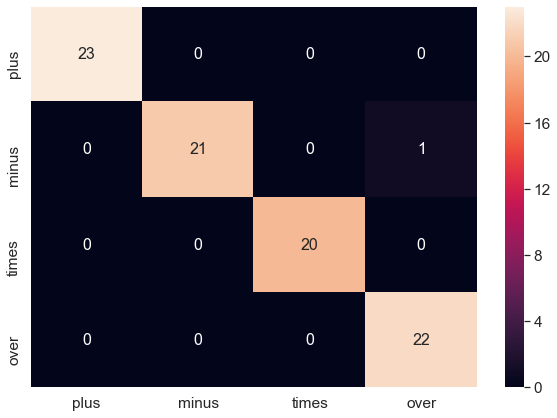

In [27]:
pred = op_rfc.predict(op_test_set)
cm = confusion_matrix(op_test_label, pred)
print(cm)
df_cm = pd.DataFrame(cm, index = [i for i in op_feature_types],
                  columns = [i for i in op_feature_types])
plt.figure(figsize = (10,7))

sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
plt.show()

## SVM

In [28]:
print("Splitting")
X_train, X_val, y_train, y_val = train_test_split(digit_features, digit_labels, test_size=0.2, random_state=10, shuffle = True, stratify=digit_labels)

#print(X_train)

print("digit svm fitting...")

digit_svm = SVC(C=20.0, gamma=0.00001)
digit_svm.fit(X_train, y_train)
dig_test_acc = digit_svm.score(X_val, y_val)
dig_train_acc = digit_svm.score(X_train, y_train)
print("svm digit test accuracy =%0.3f" % dig_test_acc)
print("svm digit train accuracy =%0.3f" % dig_train_acc)

Splitting
digit svm fitting...
svm digit test accuracy =0.948
svm digit train accuracy =1.000


[[37  0  0  0  0  0  2  0  0  1]
 [ 0 36  0  2  2  0  0  0  0  0]
 [ 0  0 39  0  0  0  0  0  0  1]
 [ 0  0  0 39  0  1  0  0  0  0]
 [ 0  0  0  2 38  0  0  0  0  0]
 [ 0  0  0  2  0 37  0  0  0  1]
 [ 2  0  0  0  0  0 38  0  0  0]
 [ 0  0  0  0  0  0  1 37  1  1]
 [ 0  0  0  0  0  0  0  2 38  0]
 [ 0  0  0  0  0  0  0  0  0 40]]


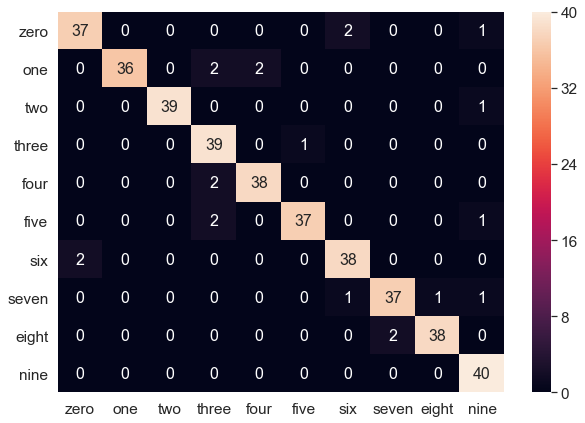

In [29]:
pred = digit_svm.predict(X_val)
cm = confusion_matrix(y_val, pred)
print(cm)
df_cm = pd.DataFrame(cm, index = [i for i in digit_feature_types],
                  columns = [i for i in digit_feature_types])
plt.figure(figsize = (10,7))

sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
plt.show()

In [30]:
X_train, X_val, y_train, y_val = train_test_split(op_features, op_labels, test_size=0.2, random_state=10, shuffle = True, stratify=op_labels)

print('operator svm fitting...')
op_svm = SVC(C=20.0, gamma=0.00001)
op_svm.fit(X_train, y_train)
op_test_acc = op_svm.score(X_val, y_val)
op_train_acc = op_svm.score(X_train, y_train)
print("svm operator test accuracy=%0.3f" % op_test_acc)
print("svm operator train accuracy=%0.3f" % op_train_acc)

operator svm fitting...
svm operator test accuracy=0.966
svm operator train accuracy=1.000


[[22  0  0  0]
 [ 0 22  0  1]
 [ 2  0 18  0]
 [ 0  0  0 22]]


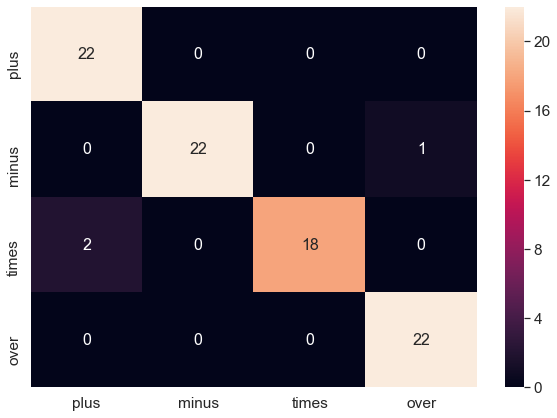

In [31]:
pred = op_svm.predict(X_val)
cm = confusion_matrix(y_val, pred)
print(cm)
df_cm = pd.DataFrame(cm, index = [i for i in op_feature_types],
                  columns = [i for i in op_feature_types])
plt.figure(figsize = (10,7))

sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
plt.show()

## Logistic regression with Adaboost

In [32]:
X_train, X_val, y_train, y_val = train_test_split(digit_features, digit_labels, test_size=0.2, random_state=10, shuffle = True, stratify=digit_labels)

#print(X_train)

print("digit adaboost with logistic fitting...")

digit_ada_log = AdaBoostClassifier(LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', penalty = 'l2', max_iter = 10000), n_estimators=100, random_state=0)
digit_ada_log.fit(X_train, y_train)
dig_test_acc = digit_ada_log.score(X_val, y_val)
dig_train_acc = digit_ada_log.score(X_train, y_train)
print("digit adaboost with logistic test accuracy =%0.3f" % dig_test_acc)
print("digit adaboost with logistic train accuracy =%0.3f" % dig_train_acc)

digit adaboost with logistic fitting...
digit adaboost with logistic test accuracy =0.833
digit adaboost with logistic train accuracy =1.000


[[32  0  3  0  0  1  2  1  1  0]
 [ 0 30  2  1  3  2  1  0  0  1]
 [ 0  1 36  0  1  0  1  0  1  0]
 [ 0  1  0 34  2  3  0  0  0  0]
 [ 0  0  0  4 36  0  0  0  0  0]
 [ 0  0  0  0  1 35  1  1  2  0]
 [ 4  0  0  2  0  1 30  2  1  0]
 [ 5  0  0  0  0  0  3 28  4  0]
 [ 1  1  0  0  0  0  1  2 35  0]
 [ 0  0  1  0  0  1  1  0  0 37]]


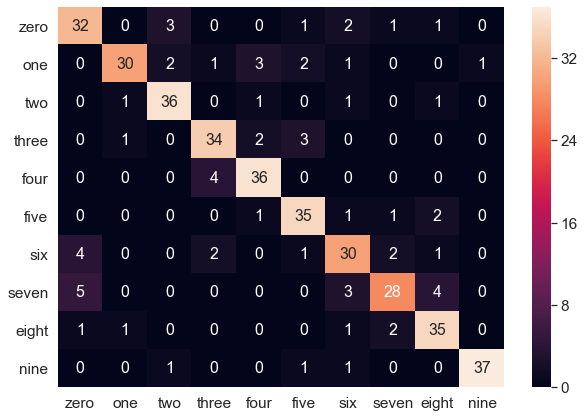

In [33]:
pred = digit_ada_log.predict(X_val)
cm = confusion_matrix(y_val, pred)
print(cm)
df_cm = pd.DataFrame(cm, index = [i for i in digit_feature_types],
                  columns = [i for i in digit_feature_types])
plt.figure(figsize = (10,7))

sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
plt.show()

In [34]:
print("Splitting")
X_train, X_val, y_train, y_val = train_test_split(op_features, op_labels, test_size=0.2, random_state=10, shuffle = True, stratify=op_labels)

print("operator adaboost with logistic fitting...")

op_ada_log = AdaBoostClassifier(LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', penalty = 'l2', max_iter = 10000), n_estimators=100, random_state=0)
op_ada_log.fit(X_train, y_train)
op_test_acc = op_ada_log.score(X_val, y_val)
op_train_acc = op_ada_log.score(X_train, y_train)
print("operator adaboost with logistic test accuracy =%0.3f" % op_test_acc)
print("operator adaboost with logistic train accuracy =%0.3f" % op_train_acc)

Splitting
operator adaboost with logistic fitting...
operator adaboost with logistic test accuracy =0.954
operator adaboost with logistic train accuracy =1.000


[[22  0  0  0]
 [ 0 22  0  1]
 [ 2  1 17  0]
 [ 0  0  0 22]]


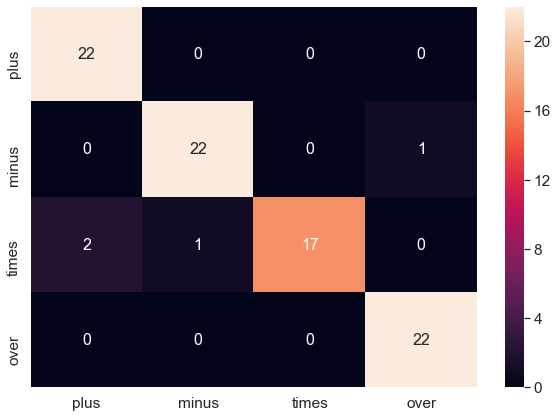

In [35]:
pred = op_ada_log.predict(X_val)
cm = confusion_matrix(y_val, pred)
print(cm)
df_cm = pd.DataFrame(cm, index = [i for i in op_feature_types],
                  columns = [i for i in op_feature_types])
plt.figure(figsize = (10,7))

sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
plt.show()

## Adaboost with Random Forest 

In [36]:
print("Splitting")
X_train, X_val, y_train, y_val = train_test_split(digit_features, digit_labels, test_size=0.2, random_state=10, shuffle = True, stratify=digit_labels)

#print(X_train)

print("digit adaboost with random forest fitting...")

digit_ada_rf = AdaBoostClassifier(RandomForestClassifier(n_estimators = 150), n_estimators=100, random_state=0)
digit_ada_rf.fit(X_train, y_train)
dig_test_acc = digit_ada_rf.score(X_val, y_val)
dig_train_acc = digit_ada_rf.score(X_train, y_train)
print("digit adaboost with random forest test accuracy =%0.3f" % dig_test_acc)
print("digit adaboost with random forest train accuracy =%0.3f" % dig_train_acc)

Splitting
digit adaboost with random forest fitting...
digit adaboost with random forest test accuracy =0.895
digit adaboost with random forest train accuracy =1.000


[[36  0  0  0  0  0  2  2  0  0]
 [ 0 31  3  2  2  0  0  0  1  1]
 [ 0  0 39  0  1  0  0  0  0  0]
 [ 0  0  0 39  0  1  0  0  0  0]
 [ 0  0  0  3 37  0  0  0  0  0]
 [ 0  0  0  2  0 38  0  0  0  0]
 [ 6  0  0  0  0  0 31  3  0  0]
 [ 0  0  0  0  0  2  1 34  2  1]
 [ 0  0  0  0  0  0  0  3 37  0]
 [ 0  0  0  0  0  3  1  0  0 36]]


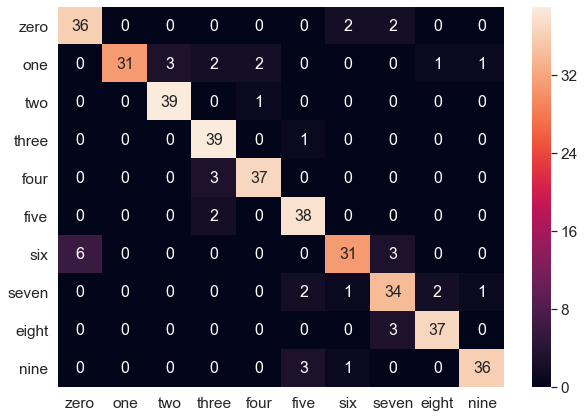

In [37]:
pred = digit_ada_rf.predict(X_val)
cm = confusion_matrix(y_val, pred)
print(cm)
df_cm = pd.DataFrame(cm, index = [i for i in digit_feature_types],
                  columns = [i for i in digit_feature_types])
plt.figure(figsize = (10,7))

sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
plt.show()

In [38]:
X_train, X_val, y_train, y_val = train_test_split(op_features, op_labels, test_size=0.2, random_state=10, shuffle = True, stratify=op_labels)

print("operator adaboost with random forest fitting...")

op_ada_rf = AdaBoostClassifier(RandomForestClassifier(n_estimators = 150), n_estimators=100, random_state=0)
op_ada_rf.fit(X_train, y_train)
op_test_acc = op_ada_rf.score(X_val, y_val)
op_train_acc = op_ada_rf.score(X_train, y_train)
print("operator adaboost rf test accuracy =%0.3f" % op_test_acc)
print("operator adaboost rf train accuracy =%0.3f" % op_train_acc)

operator adaboost with random forest fitting...
operator adaboost rf test accuracy =0.966
operator adaboost rf train accuracy =1.000


[[22  0  0  0]
 [ 0 22  0  1]
 [ 1  0 18  1]
 [ 0  0  0 22]]


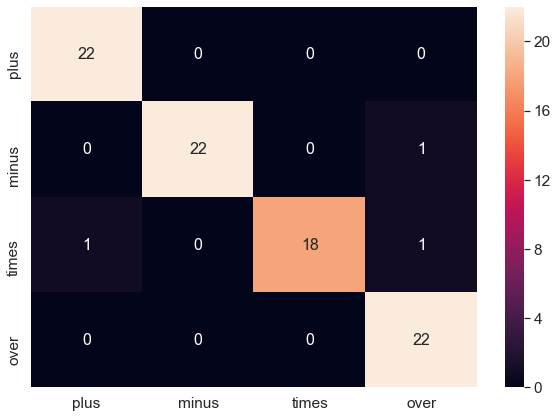

In [39]:
pred = op_ada_rf.predict(X_val)
cm = confusion_matrix(y_val, pred)
print(cm)
df_cm = pd.DataFrame(cm, index = [i for i in op_feature_types],
                  columns = [i for i in op_feature_types])
plt.figure(figsize = (10,7))

sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
plt.show()

## histgradientboostingclassifier (memory error)

In [40]:
# X_train, X_val, y_train, y_val = train_test_split(digit_features, digit_labels, test_size=0.2, random_state=10, shuffle = True, stratify=digit_labels)

# #parameters to tune
# parameters = {
#   'histgradientboostingclassifier__max_iter': [1000,1200,1500],
#   'histgradientboostingclassifier__learning_rate': [0.1],
#   'histgradientboostingclassifier__max_depth': [25, 50, 75],
#   'histgradientboostingclassifier__l2_regularization': [1.5],
#   'histgradientboostingclassifier__scoring': ['f1_micro'],
#   'histgradientboostingclassifier__random_state': [123]
#  }

# print("Fitting model")
# clf = HistGradientBoostingClassifier(max_iter = 5, max_depth = 15, scoring = 'f1_micro', verbose = 2).fit(X_train, y_train)
# print(clf.score())
# #instantiate the gridsearch
# #hgb_grid = GridSearchCV(HistGradientBoostingClassifier, parameters, n_jobs=5,  cv=5, scoring= 'f1_micro', verbose=2, refit=True)
# #fit on the grid 
# #hgb_grid.fit(X_train, y_train)

In [41]:
models = ["svm", "logistic", "rf", "adaboost with rf", "adaboost with logistic"]

def test_sig(sig, rate, now = "digit", enable_plot = False):
    
    mfcc_feat = mfcc(sig, rate, nfft=1536)
    fbank_feat = logfbank(sig, rate, nfft=1536)
   
    acoustic_features = mfcc_feat
    acoustic_features = join_features(mfcc_feat, fbank_feat)
    acoustic_features = acoustic_features.flatten()
    
    result = []
    if now == "digit":
        #acoustic_features = digit_scaler.transform(acoustic_features.reshape(1,-1))
        #acoustic_features = digit_pca.transform(acoustic_features)
        #print(acoustic_features.shape)
        result.append(digit_svm.predict(acoustic_features.reshape(1, -1)))
        result.append(digit_logisticRegr.predict(acoustic_features.reshape(1,-1)))
        result.append(digit_rfc.predict(acoustic_features.reshape(1,-1)))
        result.append(digit_ada_rf.predict(acoustic_features.reshape(1,-1)))
        result.append(digit_ada_log.predict(acoustic_features.reshape(1,-1)))
    else:
        result.append(op_svm.predict(acoustic_features.reshape(1, -1)))
        result.append(op_logisticRegr.predict(acoustic_features.reshape(1,-1)))
        result.append(op_rfc.predict(acoustic_features.reshape(1,-1)))
        result.append(op_ada_rf.predict(acoustic_features.reshape(1,-1)))
        result.append(op_ada_log.predict(acoustic_features.reshape(1,-1)))
                 
    count = np.zeros(10)
    
    for i in range(0, 5):
        print(models[i], result[i])
        if now == "digit":
            for j in range(0, 10):
                if digit_feature_types[j] == result[i]:
                    count[j] = count[j] + 1
                    if i >= 3:
                        count[j] = count[j] + 1
                    break
        if now == "operator":
            for j in range(0, 5):
                if op_feature_types[j] == result[i]:
                    count[j] = count[j] + 1
                    if i >= 3:
                        count[j] = count[j] + 1
                    break
    return count

def read_and_test_file(directory, t = "digit", enable_plot = False):
    os.chdir(cwd+"\\recording data\\"+directory)
    files = glob.glob(os.path.join(os.getcwd(), '*.wav') )
    file_n = 0
    for file in files:
        file_n = file_n + 1
        now = t
        if now == "formula":
            if file_n % 2 == 1:
                now = "digit"
            else:
                now = "operator"
        (rate,sig) = wav.read(file)
        sig, sample_rate = librosa.core.load(file)
        sig = preprocess(sig, enable_plot = True)
        
        count = test_sig(sig, rate, now)
               
        print(file)     
        if t == "formula":
            if file_n == 1:
                digit1 = np.argmax(count)
            if file_n == 2:
                op = np.argmax(count)
            if file_n == 3:
                digit2 = np.argmax(count)
                print("\nFormula acquired!")
                print("The formula is: ", digit1, op_feature_types[op], digit2)
                
                if op == 0:
                    print("The answer is:", digit1 + digit2)
                if op == 1:
                    print("The answer is:", digit1 - digit2)
                if op == 2:
                    print("The answer is:", digit1 * digit2)
                if op == 3:
                    if digit2 == 0:
                        print("denominator couldn't be 0")
                    else:
                        print("The answer is:", digit1 / digit2)

def truncate_and_test_audio_file(directory, filename):
    os.chdir(cwd+"\\recording data\\"+directory)
    file = glob.glob(os.path.join(os.getcwd(), filename) )[0]
    (rate,sig) = wav.read(file)
    sig, sample_rate = librosa.core.load(file)
    sig = preprocess(sig, pre_emphasis = True)
    
    norm_sig = normalize(sig)
    
    noise_start = 0
    noise_length = 0
    noise_end = 0
    for i in range(1, sig.size):
        if norm_sig[i] < truncate_threshold:
            if noise_length == 0:
                noise_start = i
            noise_length = noise_length + 1
        else:
            if noise_length > 2400:
                noise_end = i
                break
            noise_length = 0
    
    print("noise length", noise_length)
    if noise_length <= 2400:
        print("Too much noise, cannot truncate")
        return
        
    sig1 = sig[0:noise_start]
    print(noise_start)
    noise_start = 0
    noise_length = 0
    section_start = noise_end
    for i in range(section_start, sig.size):
        if norm_sig[i] < truncate_threshold:
            if noise_length == 0:
                noise_start = i
            noise_length = noise_length + 1
        else:
            if noise_length > 2400:
                noise_end = i
                break
            noise_length = 0
    
    print("noise length", noise_length)
    if noise_length <= 2400:
        print("Too much noise, cannot truncate")
        return
        
    print(section_start)
    print(noise_start)
    sig2 = sig[section_start:noise_start]
    sig3 = sig[noise_end:]
    
    sig1 = librosa.core.resample(sig1, sig1.size, truncate_size)
    sig2 = librosa.core.resample(sig2, sig2.size, truncate_size)
    sig3 = librosa.core.resample(sig3, sig3.size, truncate_size)
    
    digit1 = np.argmax(test_sig(sig1, rate, "digit"))
    op = np.argmax(test_sig(sig2, rate, "op"))
    digit2 = np.argmax(test_sig(sig3, rate, "digit"))
    
    plot_sig(sig, "sig")
    plot_sig(sig1, "sig1")
    plot_sig(sig2, "sig2")
    plot_sig(sig3, "sig3")
    
    print("\nFormula acquired!")
    print("The formula is: ", digit1, op_feature_types[op], digit2)
    
    if op == 0:
        print("The answer is:", digit1 + digit2)
    if op == 1:
        print("The answer is:", digit1 - digit2)
    if op == 2:
        print("The answer is:", digit1 * digit2)
    if op == 3:
        if digit2 == 0:
            print("denominator couldn't be 0")
        else:
            print("The answer is:", digit1 / digit2)
    

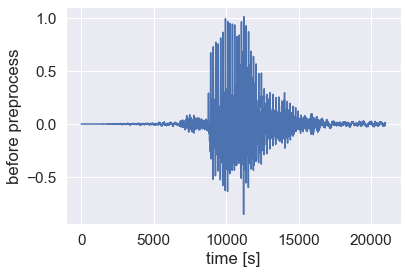

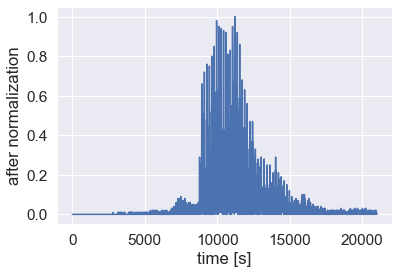

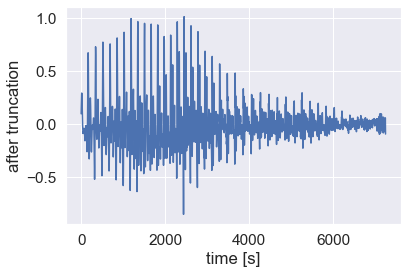

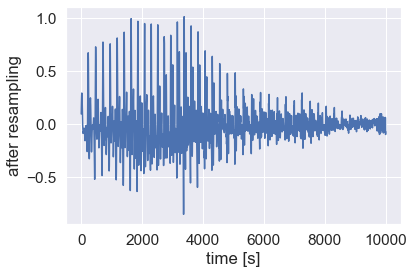

svm ['nine']
logistic ['five']
rf ['four']
adaboost with rf ['five']
adaboost with logistic ['one']
C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\formula\1.wav


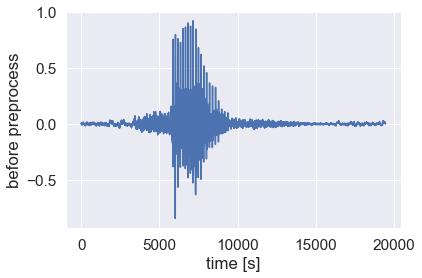

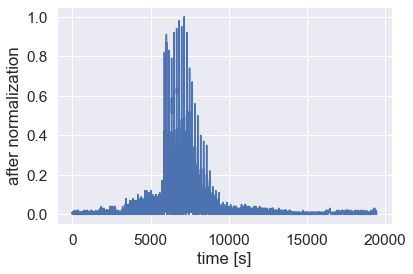

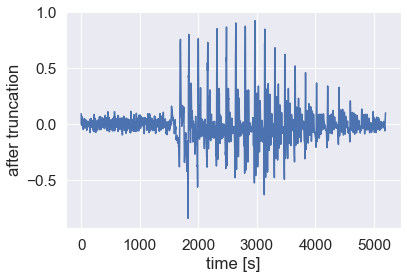

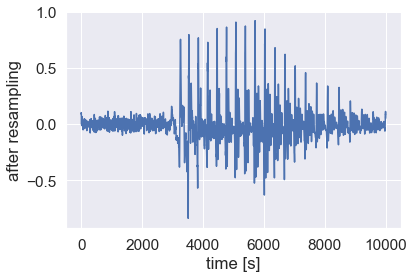

svm ['plus']
logistic ['plus']
rf ['times']
adaboost with rf ['times']
adaboost with logistic ['plus']
C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\formula\2.wav


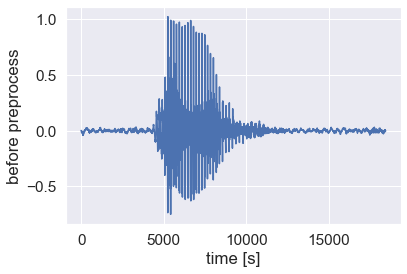

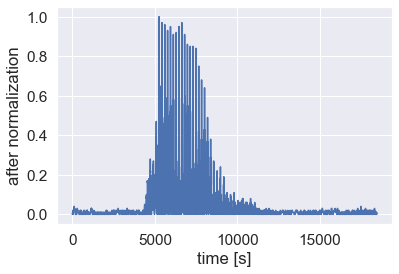

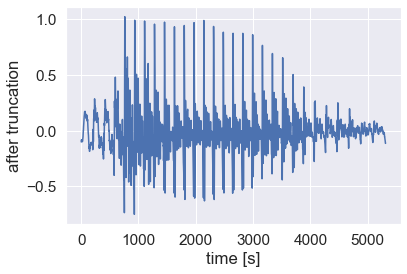

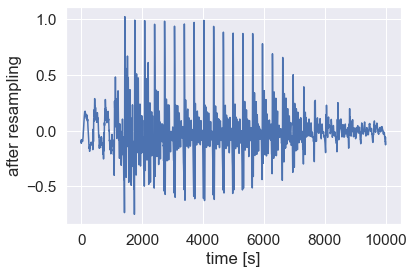

svm ['nine']
logistic ['nine']
rf ['five']
adaboost with rf ['five']
adaboost with logistic ['nine']
C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\formula\3.wav

Formula acquired!
The formula is:  5 plus 9
The answer is: 14


In [42]:
read_and_test_file("formula", "formula", False)

noise length 2543
1584
noise length 3695
4127
5154
svm ['nine']
logistic ['five']
rf ['eight']
adaboost with rf ['eight']
adaboost with logistic ['five']
svm ['times']
logistic ['plus']
rf ['plus']
adaboost with rf ['plus']
adaboost with logistic ['plus']
svm ['nine']
logistic ['one']
rf ['four']
adaboost with rf ['one']
adaboost with logistic ['one']


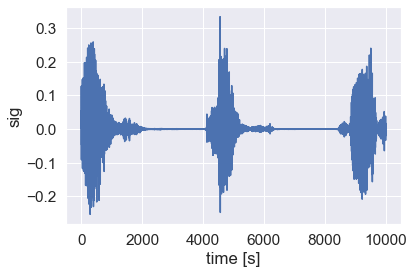

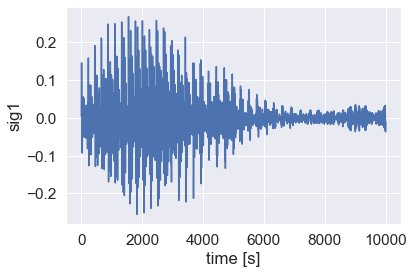

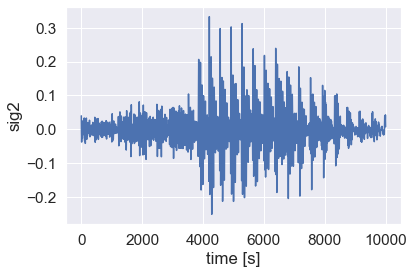

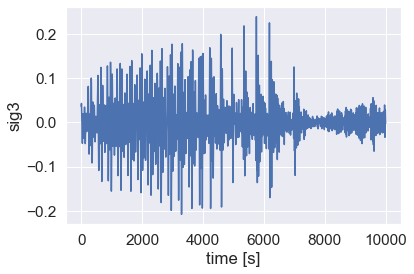


Formula acquired!
The formula is:  5 plus 1
The answer is: 6


In [43]:
truncate_and_test_audio_file("singleFile", "5times4.wav")